In [1]:
!git clone https://github.com/sebastianneri/cemexVenturesEnergyEfficiencyModelApp.git

Cloning into 'cemexVenturesEnergyEfficiencyModelApp'...
fatal: could not read Username for 'https://github.com': No such device or address


In [3]:
!rm -rf /root/.ssh
!mkdir /root/.ssh
!tar xvzf ssh.tar.gz
!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab && rm -rf ssh.tar.gz
!chmod 700 /root/.ssh
!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts
!ssh-agent /bin/bash
!git config --global user.email "sebastian_nerip@hotmail.com"
!git config --global user.name "Sebastian Neri"
!git clone git@github.com:sebastianneri/cemexVenturesEnergyEfficiencyModelApp.git

._ssh-colab
ssh-colab/
ssh-colab/config
ssh-colab/id_rsa
ssh-colab/id_rsa.pub
# github.com:22 SSH-2.0-babeld-e6c299ba
# github.com:22 SSH-2.0-babeld-e6c299ba
# github.com:22 SSH-2.0-babeld-e6c299ba
bash: cannot set terminal process group (57): Inappropriate ioctl for device
bash: no job control in this shell
/content# ssh-add /root/.ssh/id_rsa
Identity added: /root/.ssh/id_rsa (sebastianneri@MacBook-Pro-de-Sebastian.local)
/content# ssh-add -l
3072 SHA256:PzoLJQV9YOhZXMcCQTIBG+GVxRihnnj0tlly+Ee29FM sebastianneri@MacBook-Pro-de-Sebastian.local (RSA)
/content# exit
exit
Cloning into 'cemexVenturesEnergyEfficiencyModelApp'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 227 (delta 59), reused 192 (delta 37), pack-reused 0
Receiving objects: 100% (227/227), 24.11 MiB | 9.16 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


# Exploración de la base de datos

In [4]:
import os 
if os.getcwd() != "./cemexVenturesEnergyEfficiencyModelApp/research":
  os.chdir("./cemexVenturesEnergyEfficiencyModelApp/research")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from Plotting.Plots import getCBoxPlots, getTableOfScatters, removeOutliers, getHeatMap, get3DChart
from sklearn import preprocessing
from ModelEvaluation.ModelsEvaluation import ModelEvaluation
import plotly.figure_factory as ff
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [6]:
df = pd.read_csv("datos_tec.csv")

Una vez importados los datos, como sabemos que la mayoría de sus variables son cuantitativas, obtendremos un mapa de correlación, obteniendo el coeficiente de correlación de spearman.

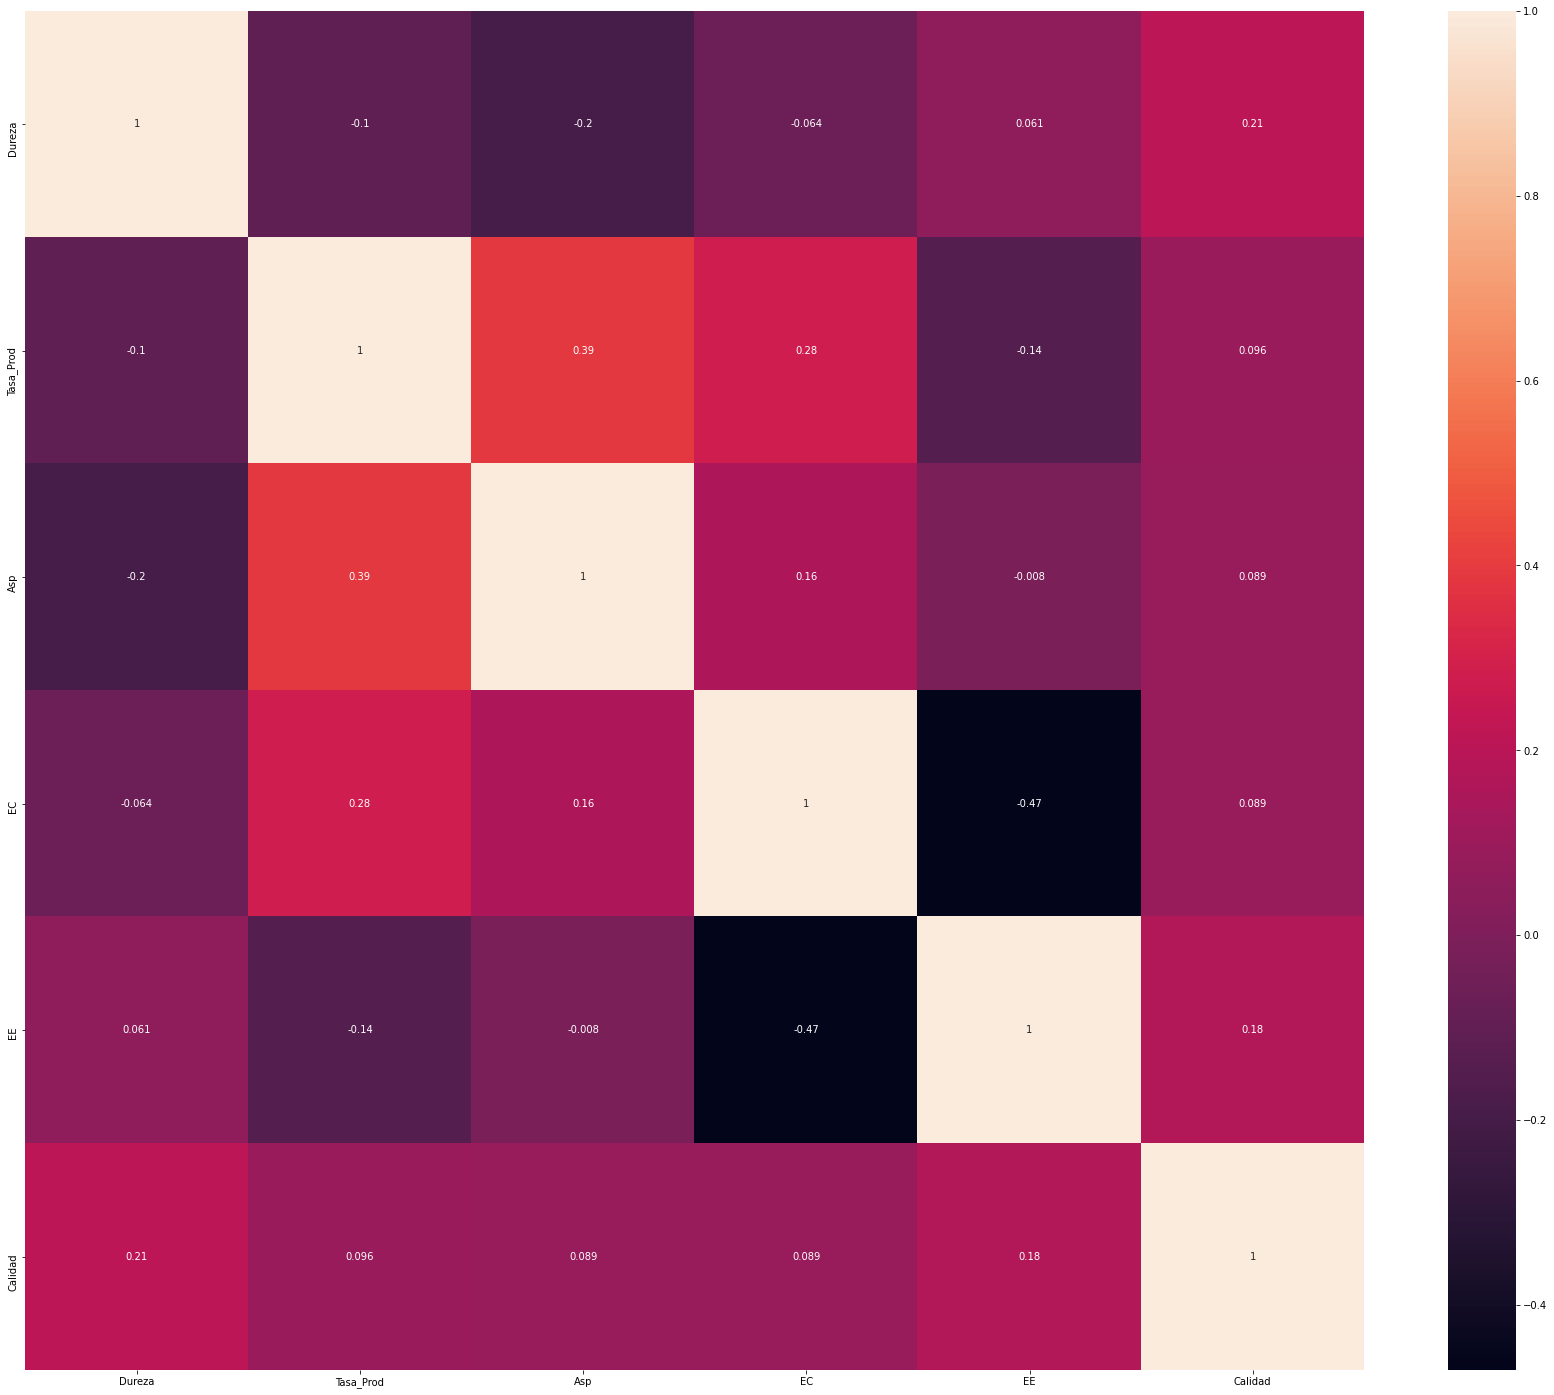

In [7]:
getHeatMap(df, 'spearman')

In [8]:
#getTableOfScatters(df)

Y a continuación se muestran las medidas de dispersión central, no central y de desviación.

In [9]:
df.describe()

Dureza    Tasa_Prod  ...           EE      Calidad
count  9391.000000  9392.000000  ...  9392.000000  9392.000000
mean    104.028644   391.005111  ...    19.059135     0.089891
std       2.049060    43.352777  ...     8.035162     0.048819
min      80.000000     0.000000  ...     0.000000     0.000000
25%     103.000000   383.000000  ...    14.200000     0.061000
50%     104.000000   398.000000  ...    20.000000     0.081000
75%     105.000000   408.000000  ...    25.200000     0.107000
max     112.000000   480.000000  ...    35.300000     1.000000

[8 rows x 6 columns]

## Valores nulos

Una vez teniendo la comprensión a rasgos generales de la base de datos, hay que limpiar los valores poco reelevantes para el análisis. En este caso se buscarán los valores que sean nulos en nuestra tabla y se eliminarán las filas que contengan dichos valores.

In [10]:
pd.isna(df).sum()

TIME         0
Dureza       1
Tasa_Prod    0
Asp          1
EC           0
EE           0
Calidad      0
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
pd.isna(df).sum()

TIME         0
Dureza       0
Tasa_Prod    0
Asp          0
EC           0
EE           0
Calidad      0
dtype: int64

Después, se eliminarán las variables que son poco reelevantes para el análisis, como lo es el tiempo y el aspirado.

In [13]:
df = df.drop(["TIME", "Asp"], axis=1)

## Outliers

Una vez eliminados los valores nulos, hay que saber si nuestra tabla contiene **outliers** para eliminarlos y que no cesguen los modelos y resultados obtenidos. Se utilizarán bocplots como visualización para identificarlos de manera máás visual, en este caso será con la función getOutliers.

In [14]:
getCBoxPlots(df, 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

En este caso podemos destacar que todas las variables cuentan con outliers, por lo que se eliminarán de todas las comlumnas.

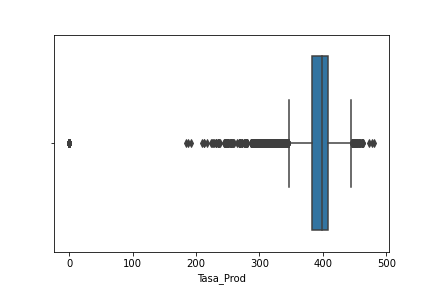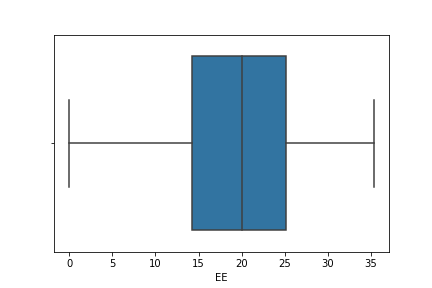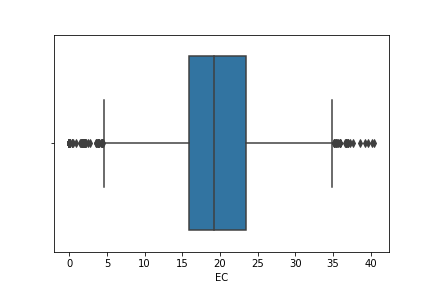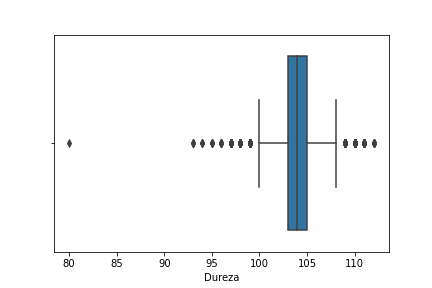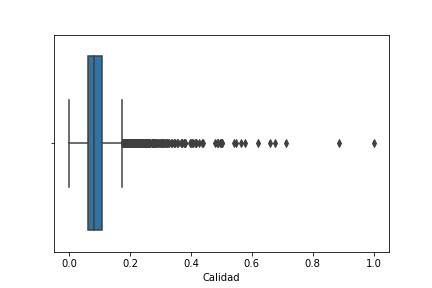


In [15]:
df.shape[0]

9390

In [16]:
df = removeOutliers(df.columns, df)

In [17]:
df["Costo"] = df["EE"] + 0.724 * df["EE"]
df["Costo_TP"] = df["Costo"] / df["Tasa_Prod"]

In [18]:
df.describe()

Dureza    Tasa_Prod  ...        Costo     Costo_TP
count  7913.000000  7913.000000  ...  7913.000000  7913.000000
mean    103.976873   398.091495  ...    33.177708     0.083831
std       1.768688    19.088949  ...    13.316201     0.034425
min     100.000000   344.000000  ...     0.000000     0.000000
25%     103.000000   386.000000  ...    25.342800     0.062081
50%     104.000000   399.000000  ...    34.652400     0.086848
75%     105.000000   410.000000  ...    43.272400     0.110117
max     108.000000   448.000000  ...    60.167600     0.171907

[8 rows x 7 columns]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7913 entries, 0 to 9391
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Dureza     7913 non-null   float64
 1   Tasa_Prod  7913 non-null   int64  
 2   EC         7913 non-null   float64
 3   EE         7913 non-null   float64
 4   Calidad    7913 non-null   float64
 5   Costo      7913 non-null   float64
 6   Costo_TP   7913 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 494.6 KB


Ahora para observar el impacto de los outliers se imprime el mapa de calor con la correlación de spearman.

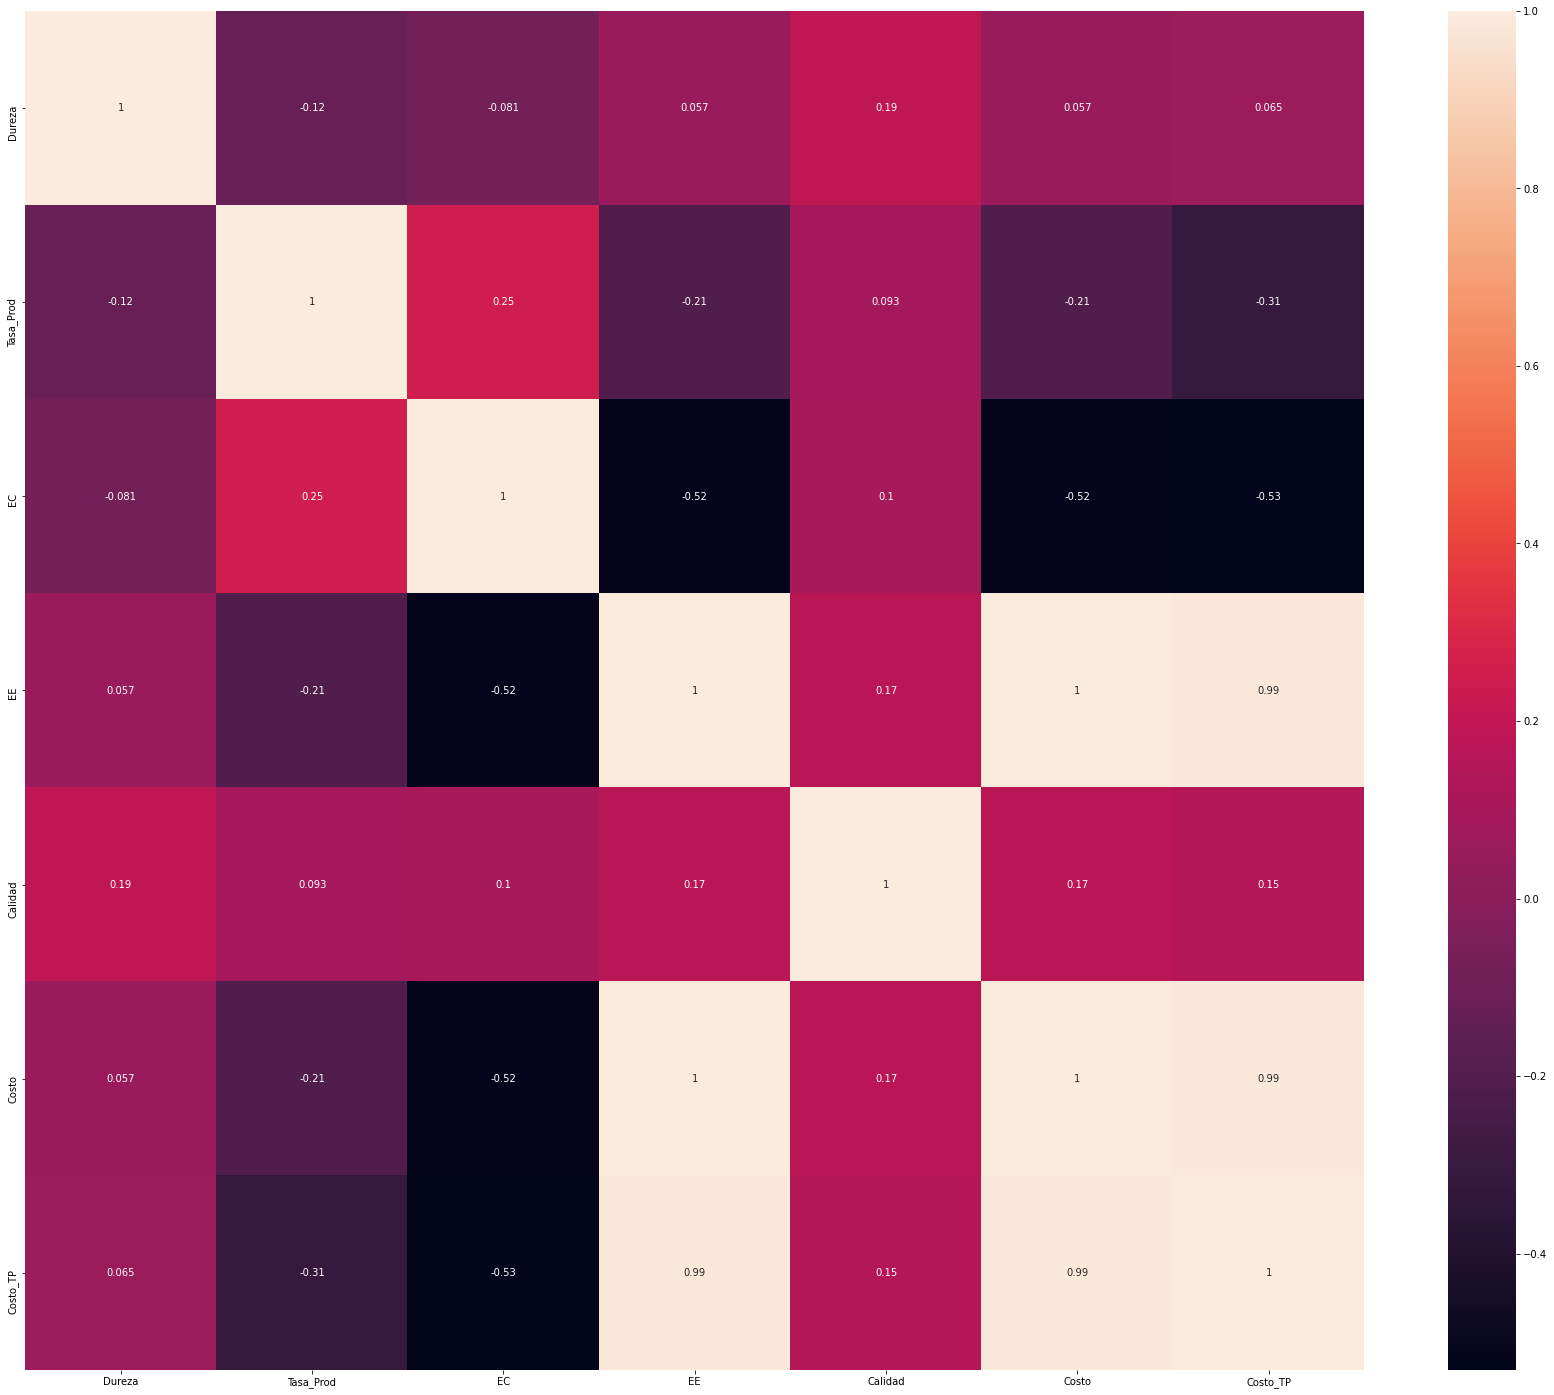

In [20]:
getHeatMap(df, 'spearman')

Se puede ver que aumentaron algunas correlaciones, lo que es bueno para nuestro análisis.

### Distribución de las variables

Para conocer el tipo de variables que tenemos, se imprime la distribución de los datos con los histogramas.

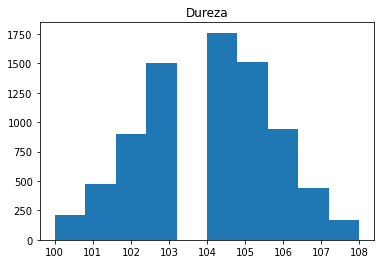

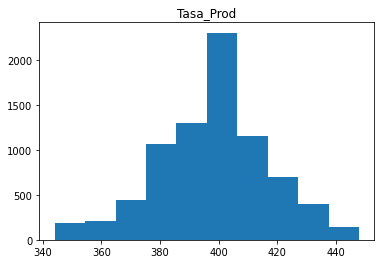

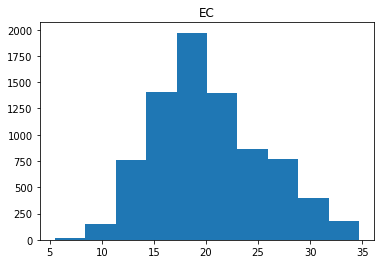

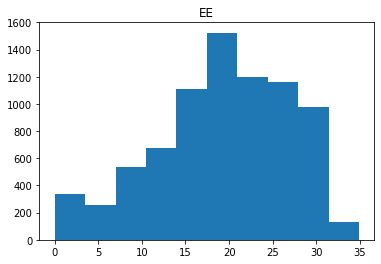

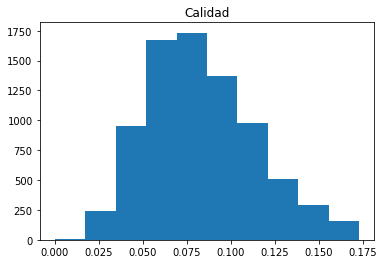

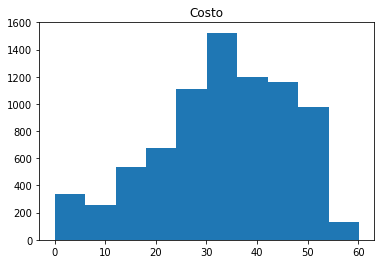

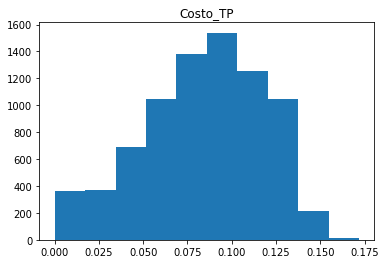

<Figure size 432x288 with 0 Axes>

In [21]:
for i in df.columns:
    plt.hist(df[i])
    plt.title(i)
    plt.show()
    plt.clf()

Ahora se buscaráán outliers restantes para evitar cesgos de cualquier tipo.

In [22]:
getCBoxPlots(df, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las cuales podemos destacar las variables de Tasa_Prod y Calidad. En este caso se dejará de lado la variable de energía calórica dado que en el costo no se v e reflejado estos outliers, por lo tanto se permitirá ese grado de error.

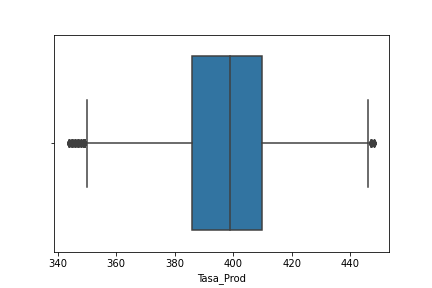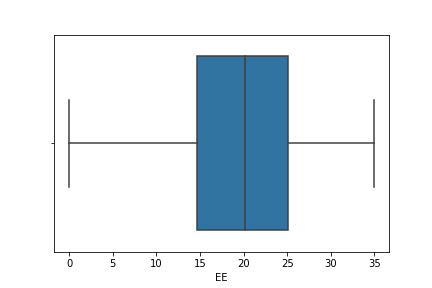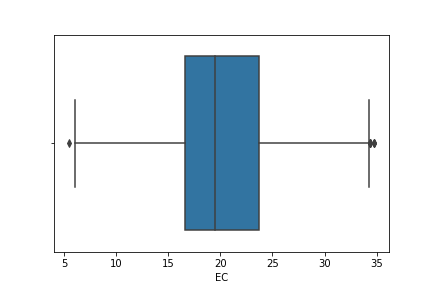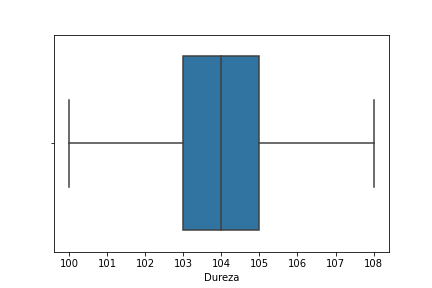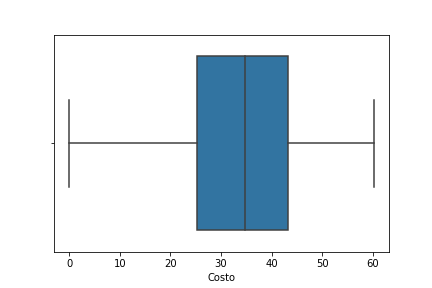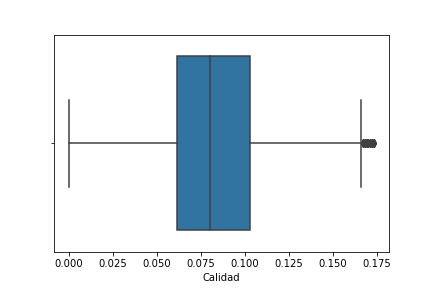

In [23]:
df = removeOutliers(["Tasa_Prod", "Calidad"], df)

In [24]:
df.shape[0]

7758

Una vez eliminados de nuevo los outliers, se verificará si no hay más por eliminar.



In [25]:
getCBoxPlots(df, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las siguientes  gráficas podemos destacar la tasa de producción. 

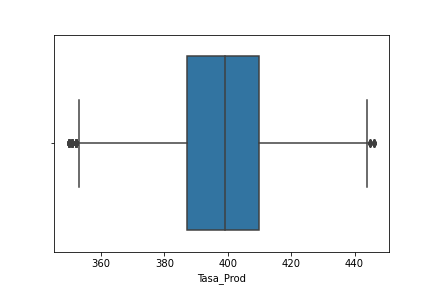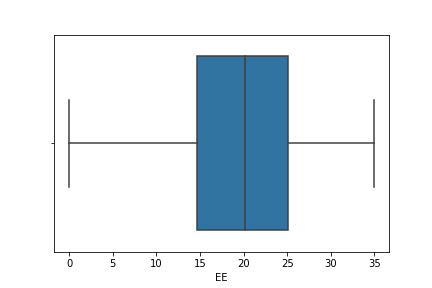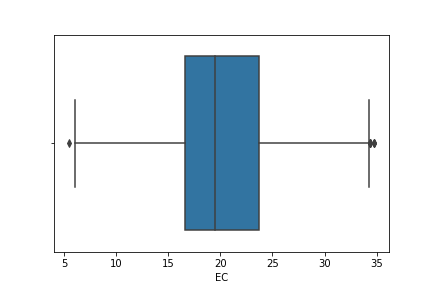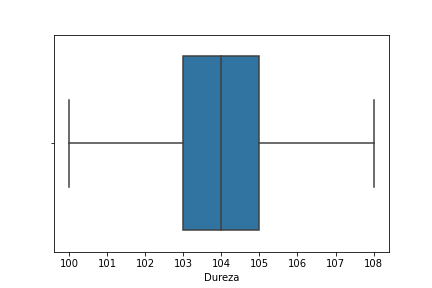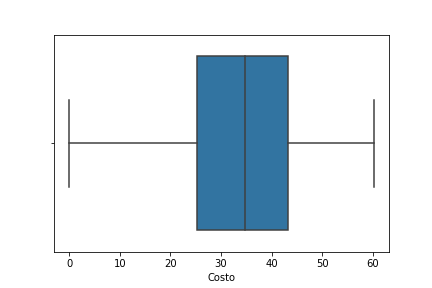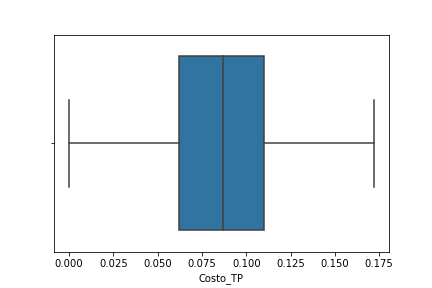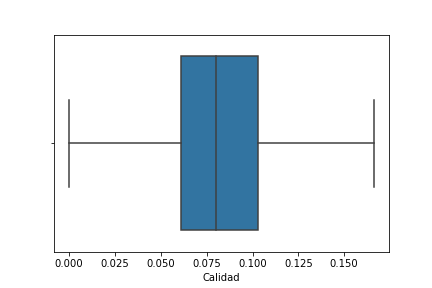

In [26]:
df = removeOutliers(["Tasa_Prod"], df)

Ahora habráá que analizar la tabla de dispersión de las variables para ver de una manera máás visual lo que dicen los datos.

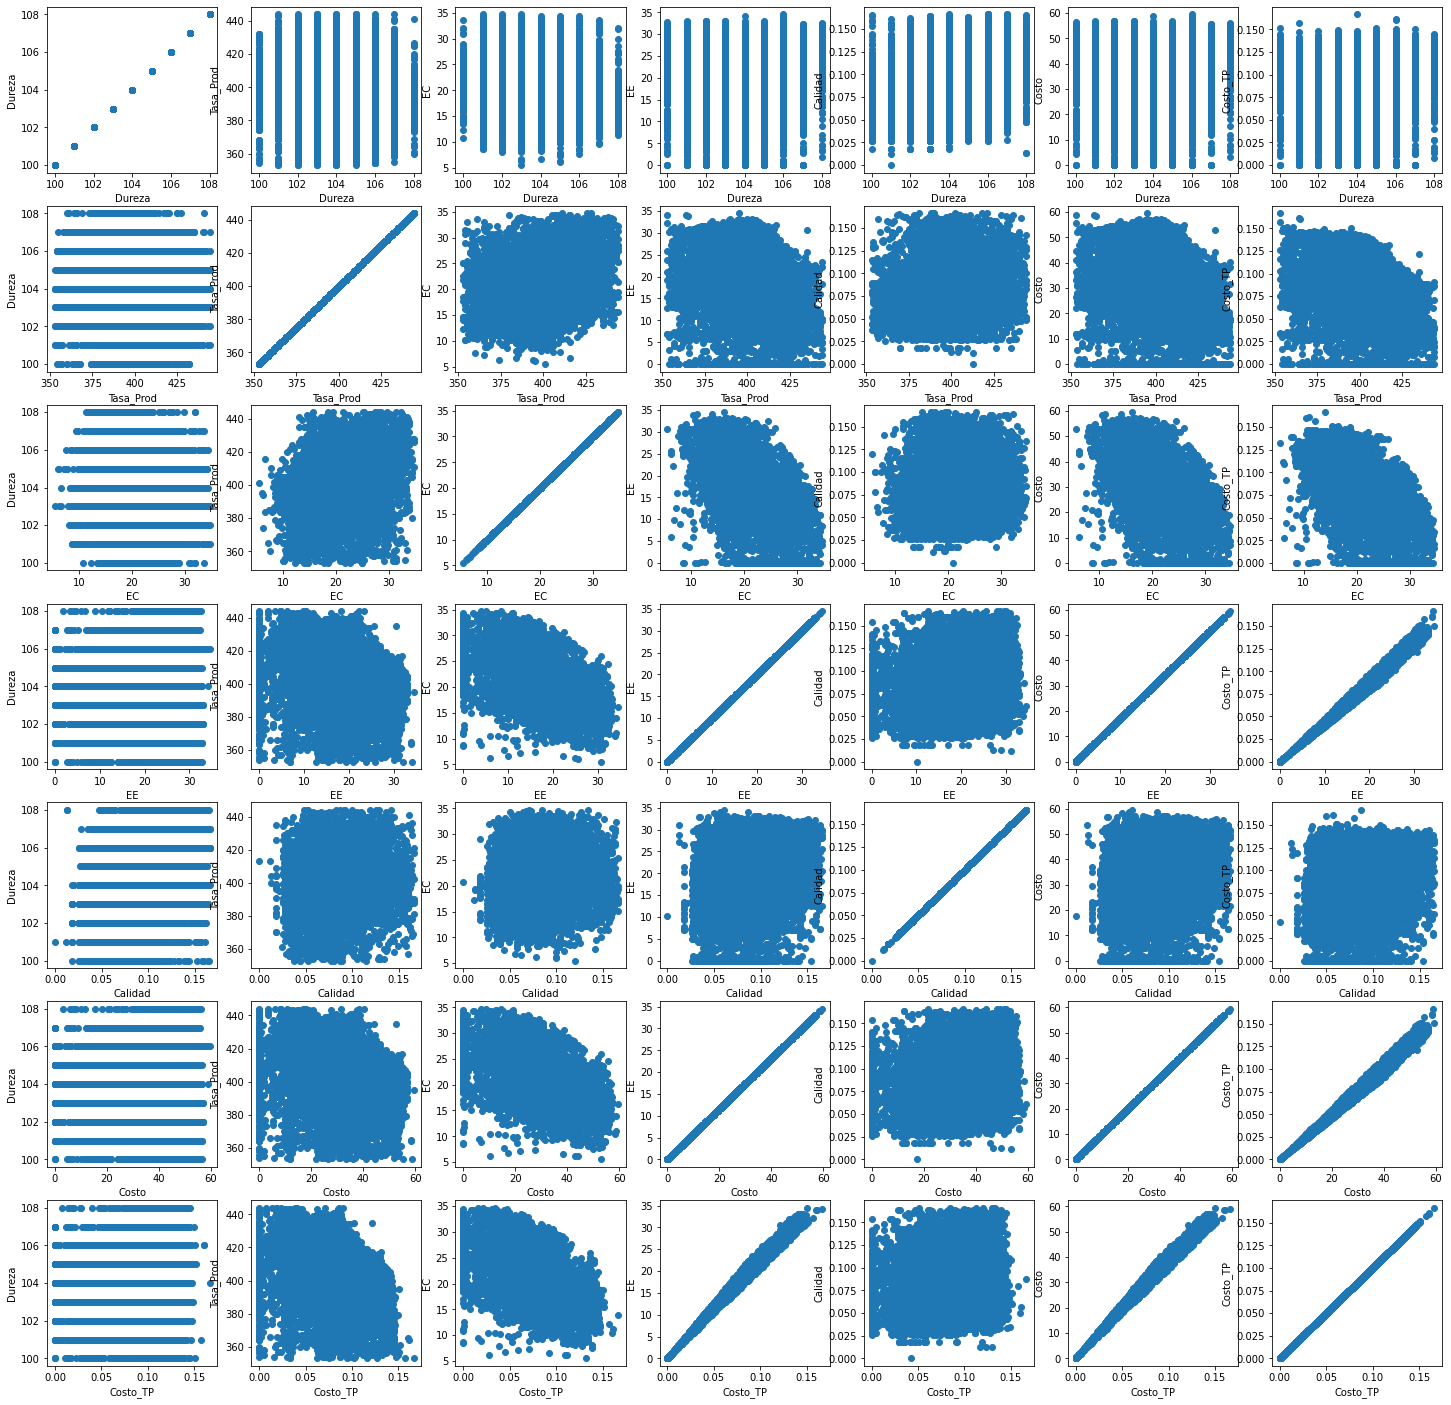

In [27]:
getTableOfScatters(df)

De la tabla de dispersiones realmente no se puede inferir nada en cuanto a la regresióón, pues las variables que se quieren utilzar como independientes no presentan una relación eviente con el costo o el costo ponderado, lo que sí muestran es un comportamiento de clusterizado que es muy evidente.

In [28]:
df.shape[0]

7678

Para finalizar, hay que rectificar que en las variables no hayan máás outliers qué remover.

In [29]:
getCBoxPlots(df, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

Y efectivamente, confirmamos que nuestras variables se encuentran limpias.

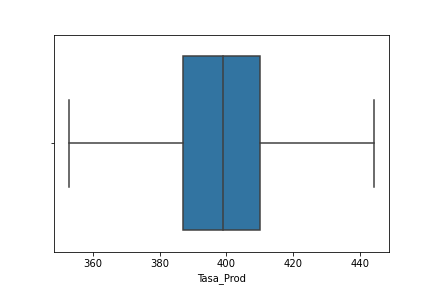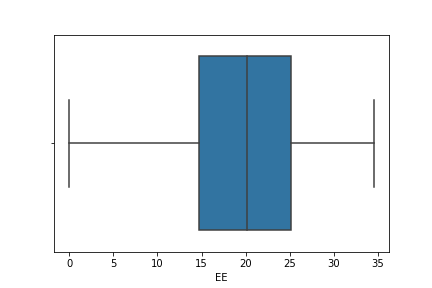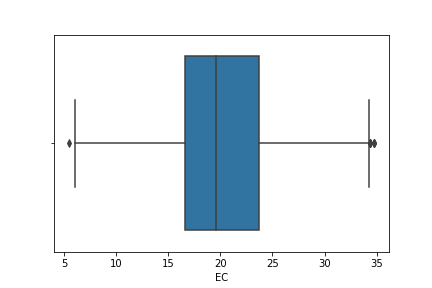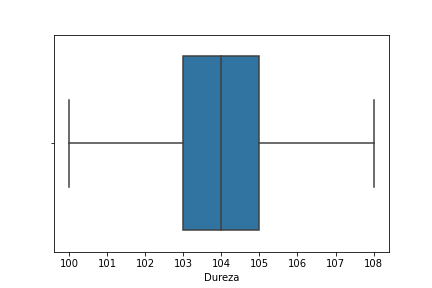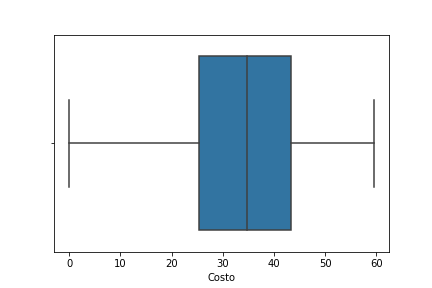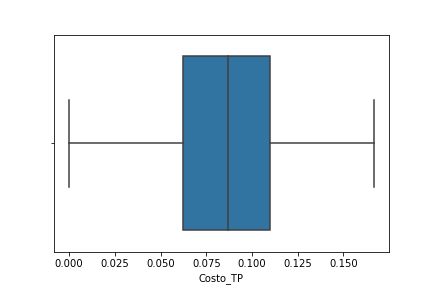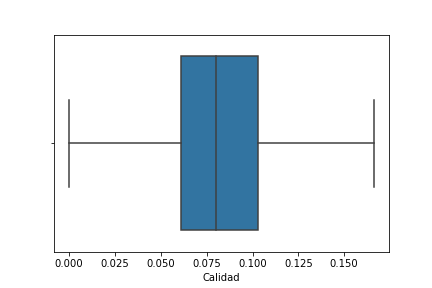

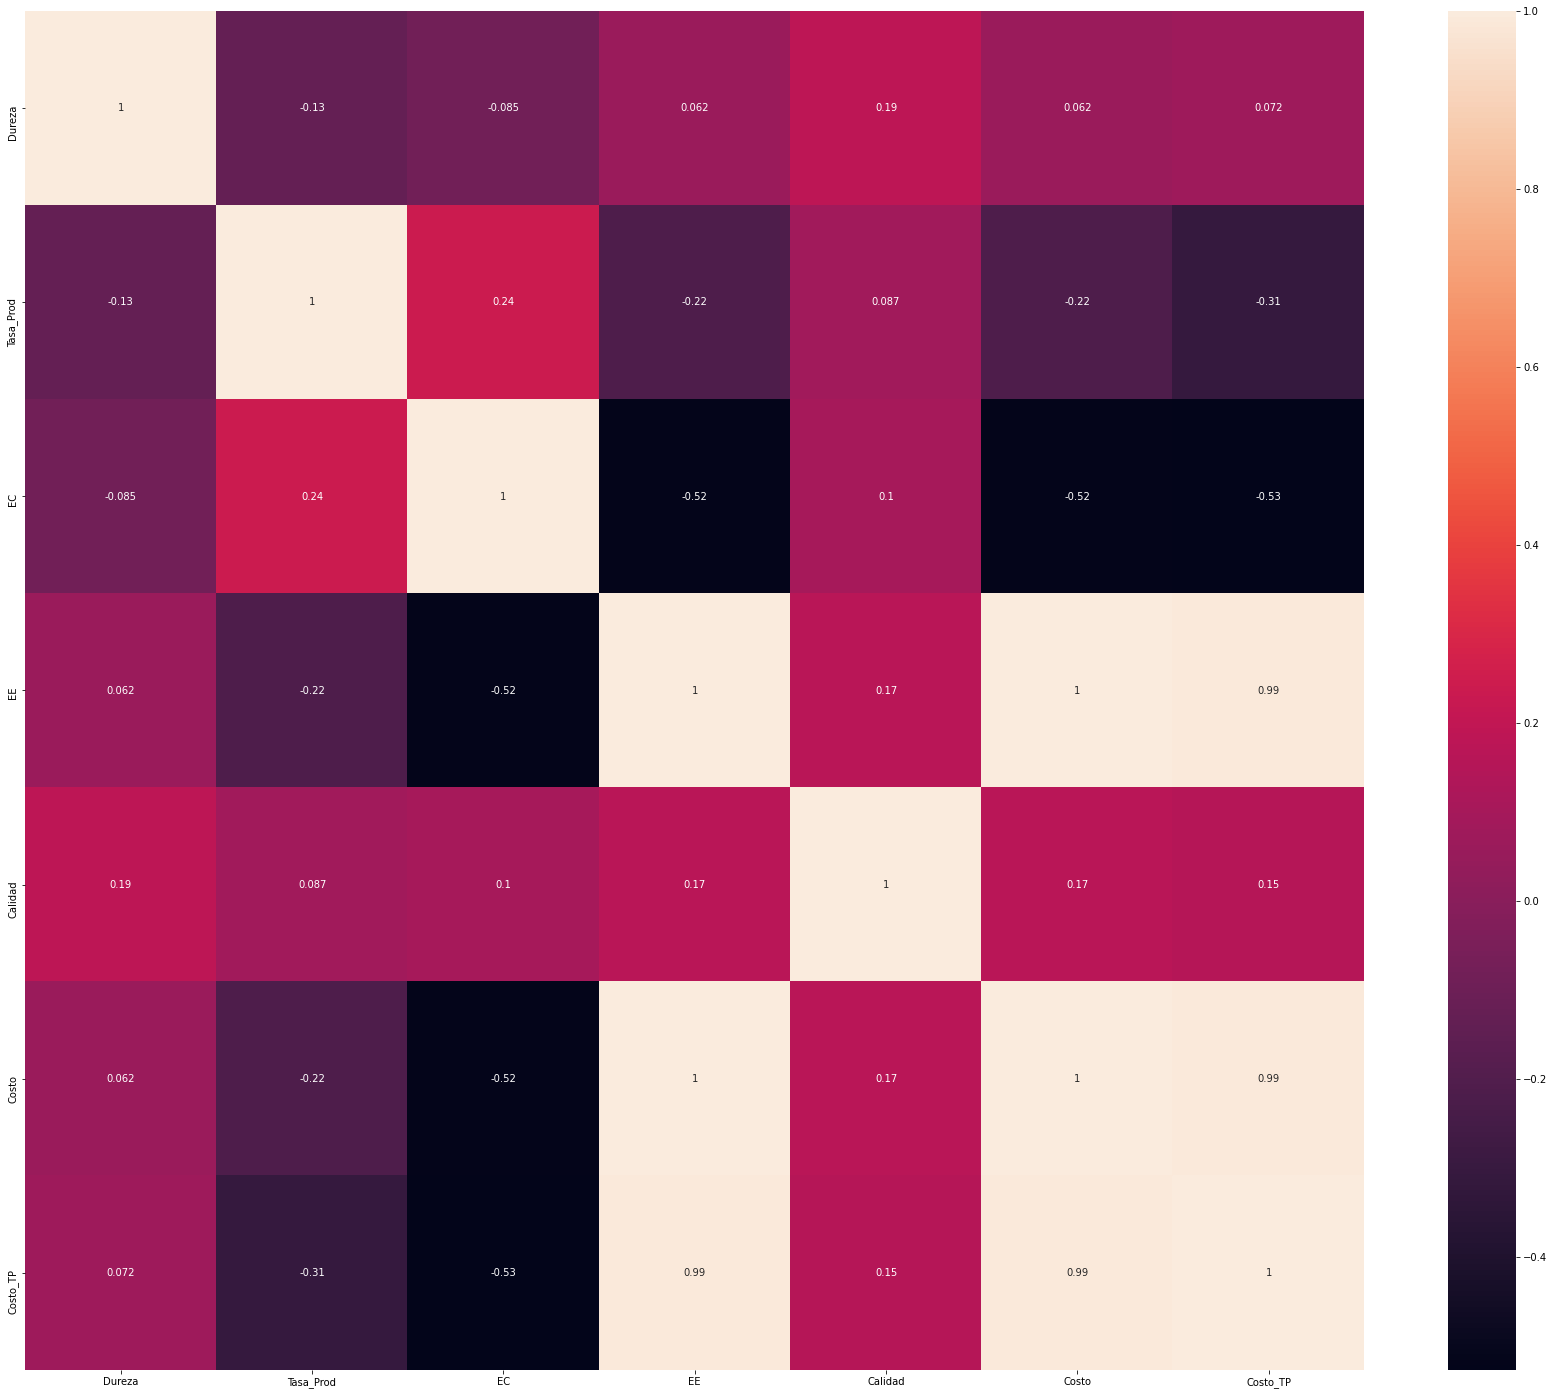

In [30]:
getHeatMap(df, 'spearman')

In [31]:
df.describe()

Dureza    Tasa_Prod  ...        Costo     Costo_TP
count  7678.000000  7678.000000  ...  7678.000000  7678.000000
mean    103.977598   398.962881  ...    33.204402     0.083678
std       1.770989    17.681486  ...    13.257862     0.034132
min     100.000000   353.000000  ...     0.000000     0.000000
25%     103.000000   387.000000  ...    25.342800     0.062100
50%     104.000000   399.000000  ...    34.652400     0.086635
75%     105.000000   410.000000  ...    43.272400     0.109899
max     108.000000   444.000000  ...    59.478000     0.166539

[8 rows x 7 columns]

## Visualización 3D

Ahora se realizaráá una visualización 3D de todas las variables para buscar algúúna relación que pueda ser evidente.

In [32]:
get3DChart(df, 10, 2, "3DAllCols")

Archivo en: file:///content/cemexVenturesEnergyEfficiencyModelApp/research/3DCharts/3DAllCols.html


## Estandarización y separación de los datos

Para trabajar con los datos de una manera más sencilla en los modelos, se normalizarán.

In [33]:
sScaler = preprocessing.StandardScaler()

In [34]:
df = pd.DataFrame(sScaler.fit_transform(df), columns=df.columns)
df.head()

Dureza  Tasa_Prod        EC        EE   Calidad     Costo  Costo_TP
0 -2.246123  -1.751261 -0.993945  1.357653 -0.993863  1.357653  1.624976
1 -2.246123   1.529220  1.261545 -2.504670  0.835159 -2.504670 -2.451745
2 -1.116736  -1.072541 -0.535201  0.954515 -1.060372  0.954515  1.084158
3  0.577343  -0.337261  1.108630 -2.504670  1.832807 -2.504670 -2.451745
4  1.706730   0.228340  1.662946 -2.114536  1.533512 -2.114536 -2.075718

In [35]:
df.describe()

Dureza     Tasa_Prod  ...         Costo      Costo_TP
count  7.678000e+03  7.678000e+03  ...  7.678000e+03  7.678000e+03
mean  -1.717766e-15 -2.993900e-16  ...  2.032743e-15  4.404092e-17
std    1.000065e+00  1.000065e+00  ...  1.000065e+00  1.000065e+00
min   -2.246123e+00 -2.599661e+00  ... -2.504670e+00 -2.451745e+00
25%   -5.520431e-01 -6.766207e-01  ... -5.930152e-01 -6.322123e-01
50%    1.265007e-02  2.099454e-03  ...  1.092252e-01  8.665602e-02
75%    5.773432e-01  6.242596e-01  ...  7.594478e-01  7.682792e-01
max    2.271423e+00  2.547300e+00  ...  1.981866e+00  2.427830e+00

[8 rows x 7 columns]

Una vez estandarizados, separaremos las variables que queremos predecir y las que utilizaremos para el entrenamiento del modelo.

In [36]:
Y = df[["EC", "EE", "Costo_TP"]]
X = df[["Dureza", "Tasa_Prod", "Calidad"]]

In [37]:
Y.describe()

EC            EE      Costo_TP
count  7.678000e+03  7.678000e+03  7.678000e+03
mean   1.117185e-15  2.518688e-15  4.404092e-17
std    1.000065e+00  1.000065e+00  1.000065e+00
min   -2.828919e+00 -2.504670e+00 -2.451745e+00
25%   -7.072298e-01 -5.930152e-01 -6.322123e-01
50%   -1.338002e-01  1.092252e-01  8.665602e-02
75%    6.498868e-01  7.594478e-01  7.682792e-01
max    2.752462e+00  1.981866e+00  2.427830e+00

In [38]:
X.describe()

Dureza     Tasa_Prod       Calidad
count  7.678000e+03  7.678000e+03  7.678000e+03
mean  -1.717766e-15 -2.993900e-16 -9.728550e-17
std    1.000065e+00  1.000065e+00  1.000065e+00
min   -2.246123e+00 -2.599661e+00 -2.756374e+00
25%   -5.520431e-01 -6.766207e-01 -7.278231e-01
50%    1.265007e-02  2.099454e-03 -9.597933e-02
75%    5.773432e-01  6.242596e-01  6.688841e-01
max    2.271423e+00  2.547300e+00  2.763945e+00

## Clusterización

Analizados los datos, se destacóó el comportamiento de cluster. Esto es reelevante, ya que apartir de esos resultados, planteamos la tésis 

"*De un conjunto de clusters $K$, cada elemento $i_j$ del cluster $K_i$ tendrá características propias de dicho cluster, por lo  que cada clúster tendrá su propio modelo de regresión.*"

Por lo que se utilizará un dendograma para conocer el número de clusters apropiados.

Text(0, 0.5, 'Distancia Euclideana')

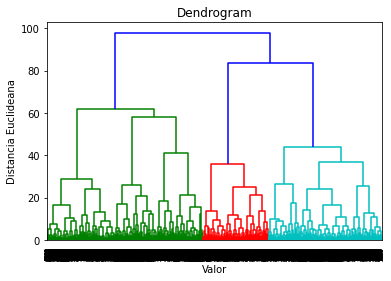

In [39]:
dendogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Valor')
plt.ylabel('Distancia Euclideana')

A partir del dendrograma anterior se utilizará el criterio de obtener el número de líneas por las que pase el trazo de una línea perpedicular en las ramas del dendograma, iniciando justo en el medio de la rama más larga .

El criterio anterior, permite identificar que se pueden dividir perfectamente los datos en 5 clusters, pues estos agrupan de manera más representativa a los datos, dichos clusters se presentan a continuación.

In [40]:
dendogram_pl = ff.create_dendrogram(X, color_threshold=5.5)
dendogram_pl.update_layout(width=800, height=500)
dendogram_pl.show()

Una vez identificados el número de clusters se utilizará el método de clusterizado aglomerativo con la distancia euclideana como criterio de agrupamiento y el algoritmo de minimización de distancias de Ward.

In [41]:
hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage="ward")
y_hc = hc.fit_predict(X)

Los valores que agrupan a cada cluster en este caso se representan de la siguiente manera.

In [42]:
pd.unique(y_hc)

array([0, 4, 3, 2, 1])

Una vez obtenidos los clusters, separaremos el dataframe en los clusters y limpiaremos cada tabla de posibles outliers.

### Cluster 1

In [43]:
cluster1 = df[y_hc == 0]
cluster1.describe()

Dureza    Tasa_Prod  ...        Costo     Costo_TP
count  2598.000000  2598.000000  ...  2598.000000  2598.000000
mean     -0.909595     0.295153  ...    -0.085736    -0.116103
std       0.642257     0.789927  ...     1.041477     1.022503
min      -2.246123    -2.543101  ...    -2.504670    -2.451745
25%      -1.116736    -0.224141  ...    -0.801086    -0.834095
50%      -0.552043     0.171780  ...     0.005190    -0.038052
75%      -0.552043     0.793940  ...     0.746443     0.701721
max       0.577343     2.547300  ...     1.799804     1.976977

[8 rows x 7 columns]

#### Outliers

Utilizaremos los box plots para saber si hay outliers o no en nuestra tabla.

In [44]:
getCBoxPlots(cluster1, "C1")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De los box plots podemos resaltar la variable de tasa de producción, dejaremos la dureza para la siguiente evaluación de outliers en caso de que la tasa de produccióón contenga estos valores.

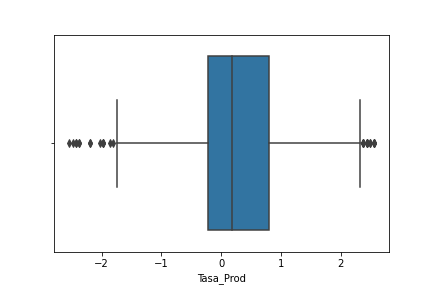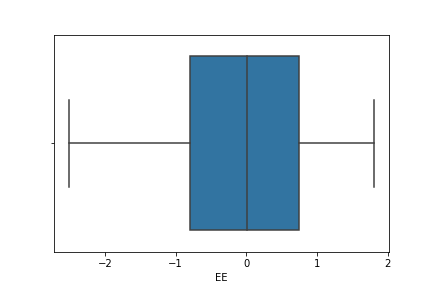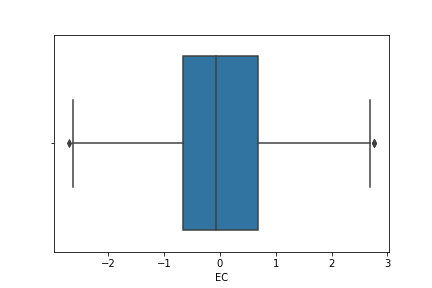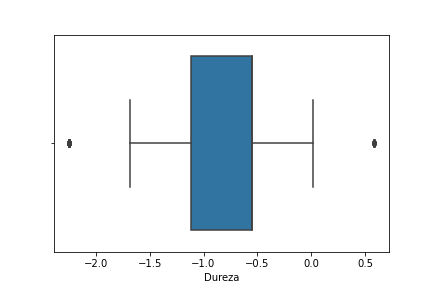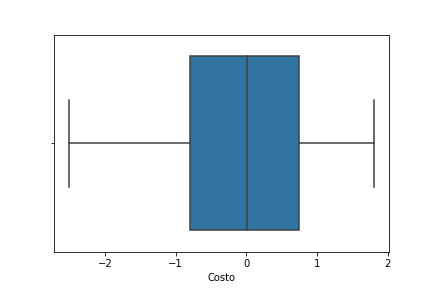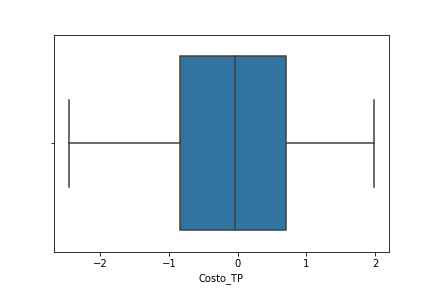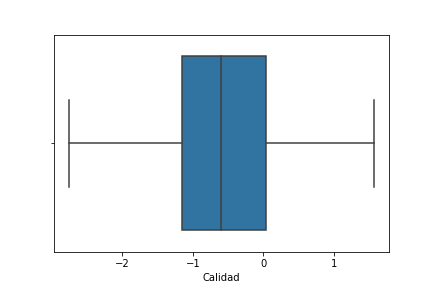

In [45]:
cluster1 = removeOutliers(["Tasa_Prod"], cluster1)

In [46]:
cluster1.shape[0]

2570

In [47]:
getCBoxPlots(cluster1, "C1-2")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las siguientes figuras podemos destacar las de tasa de producción, energíía calórica y dureza.

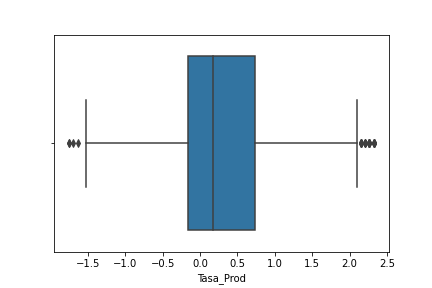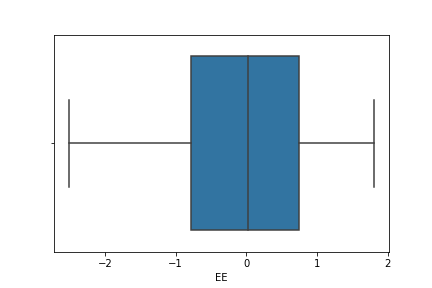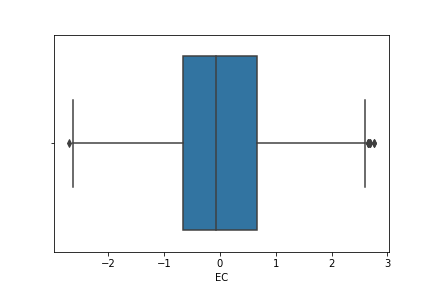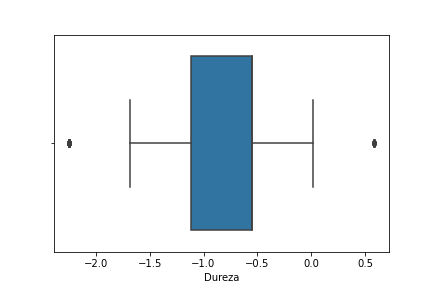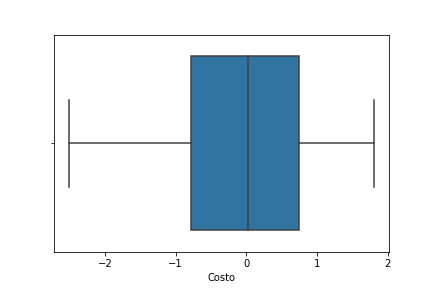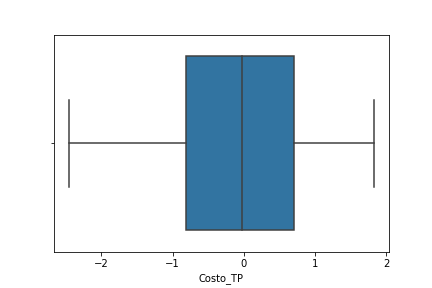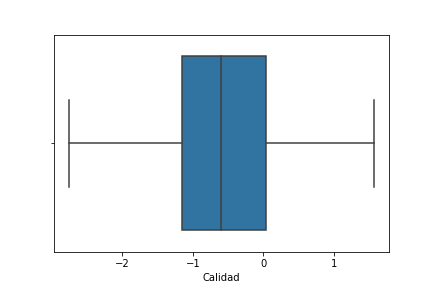

In [48]:
cluster1 = removeOutliers(["Dureza", "EC", "Tasa_Prod"], cluster1)

In [49]:
getCBoxPlots(cluster1, "C1-3")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

Se consideraron a las siguientes figuras admisibles para su uto, puesto que los outliers que contienenen no parecen tener realmente algúún peso significativo en la tabla y con los que eliminamos en la corrida pasada son suficientes.

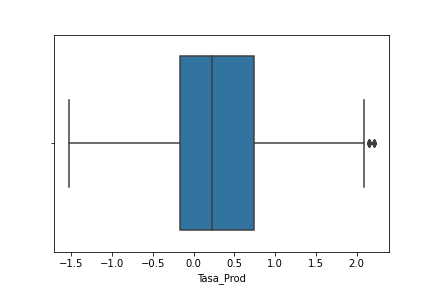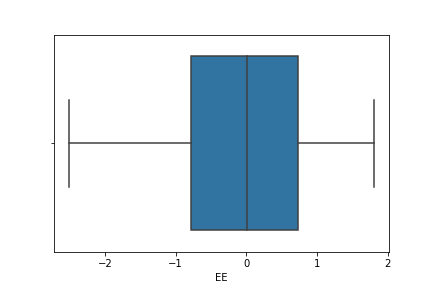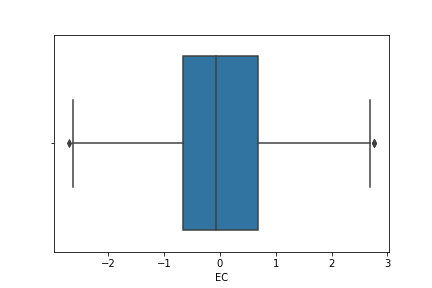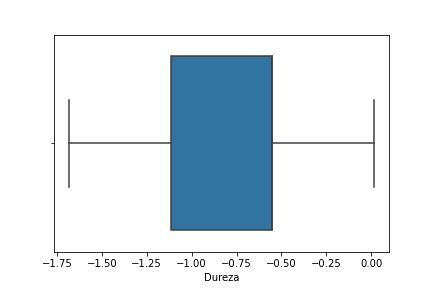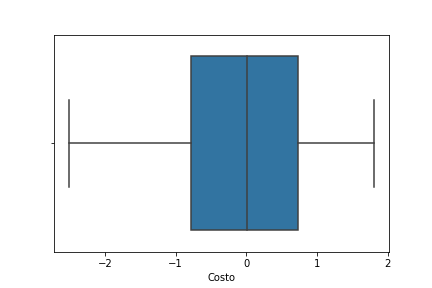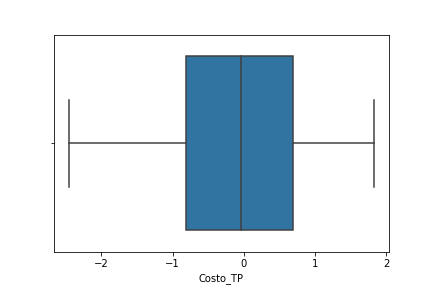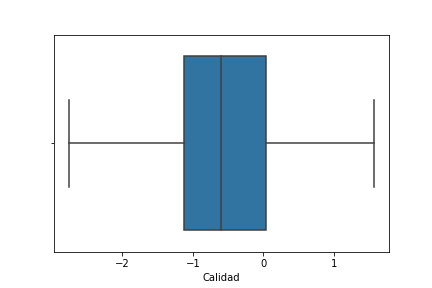

#### Análisis de Cluster y Correlación

Para finalizar obtendremos el mapa de dispersión de los datos para ver cómo están dispersadas las variables de este primer cluster.

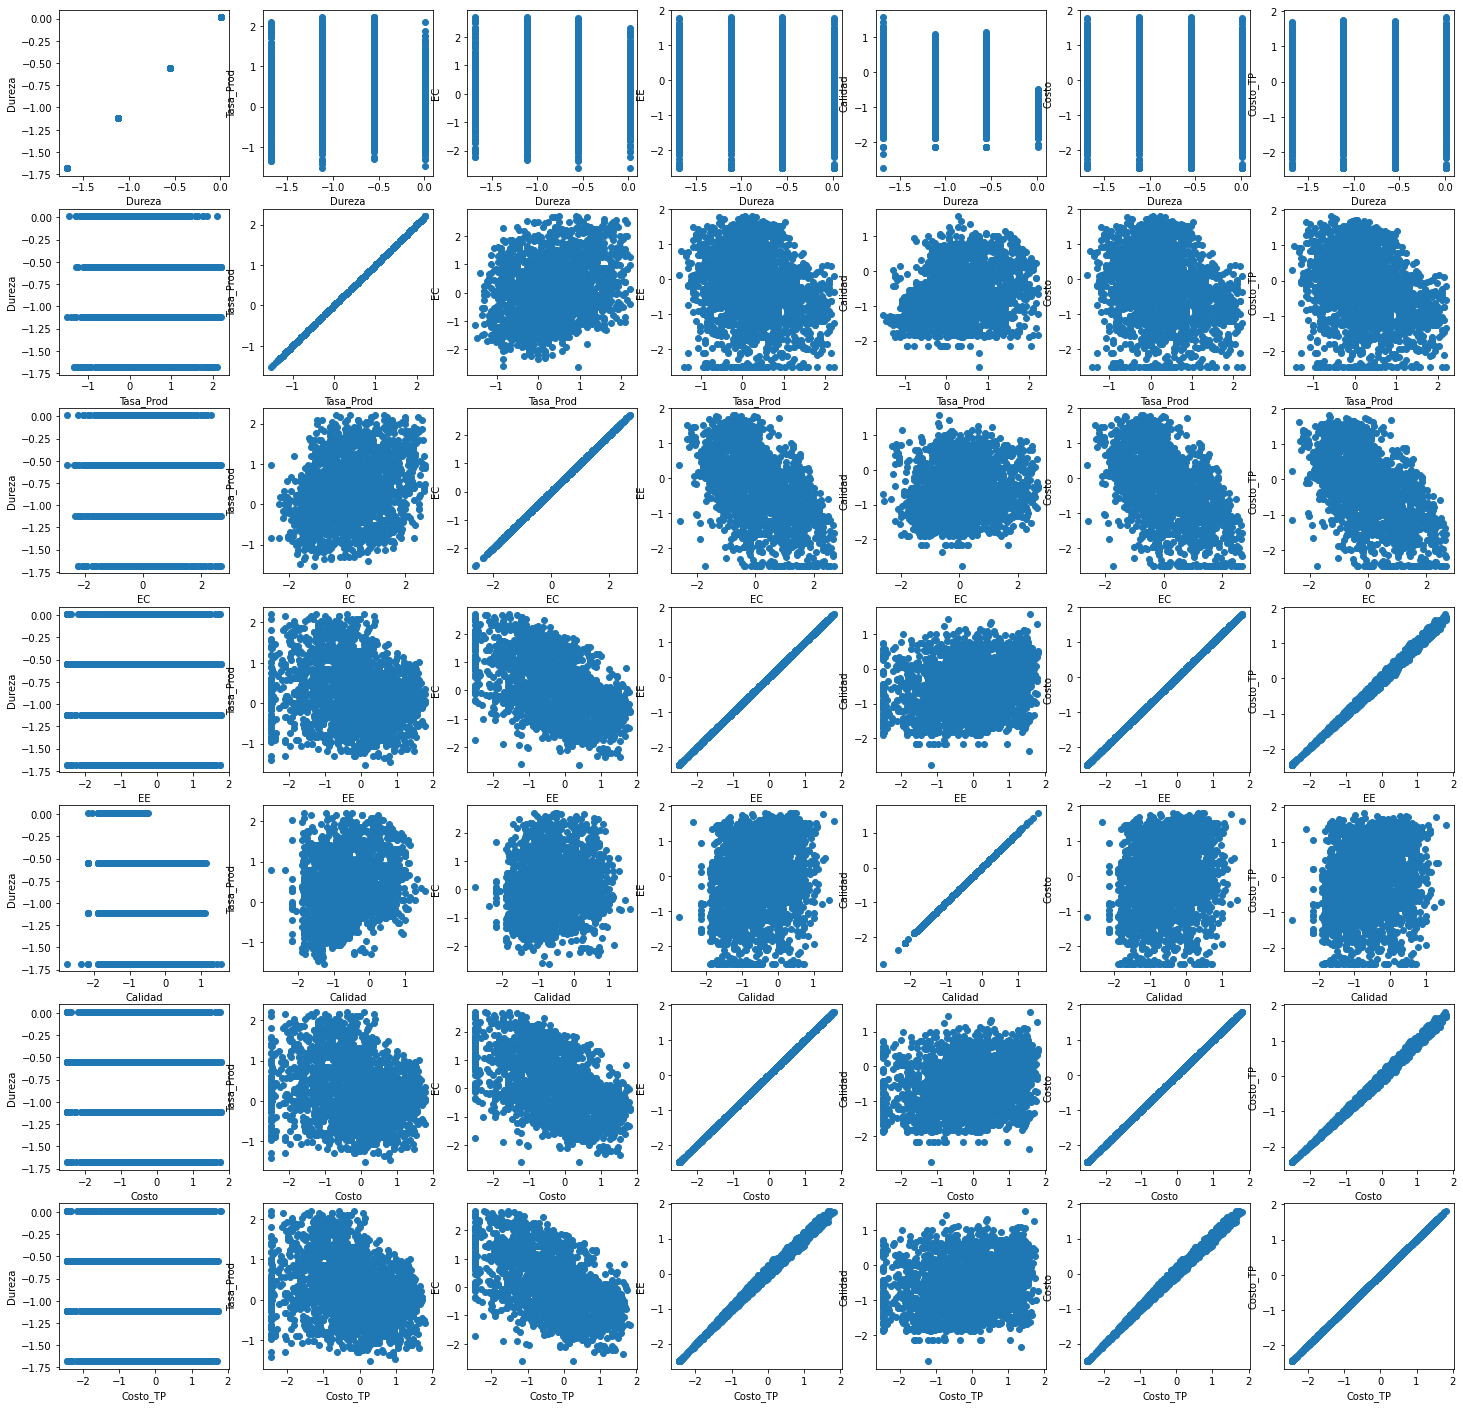

In [50]:
getTableOfScatters(cluster1)

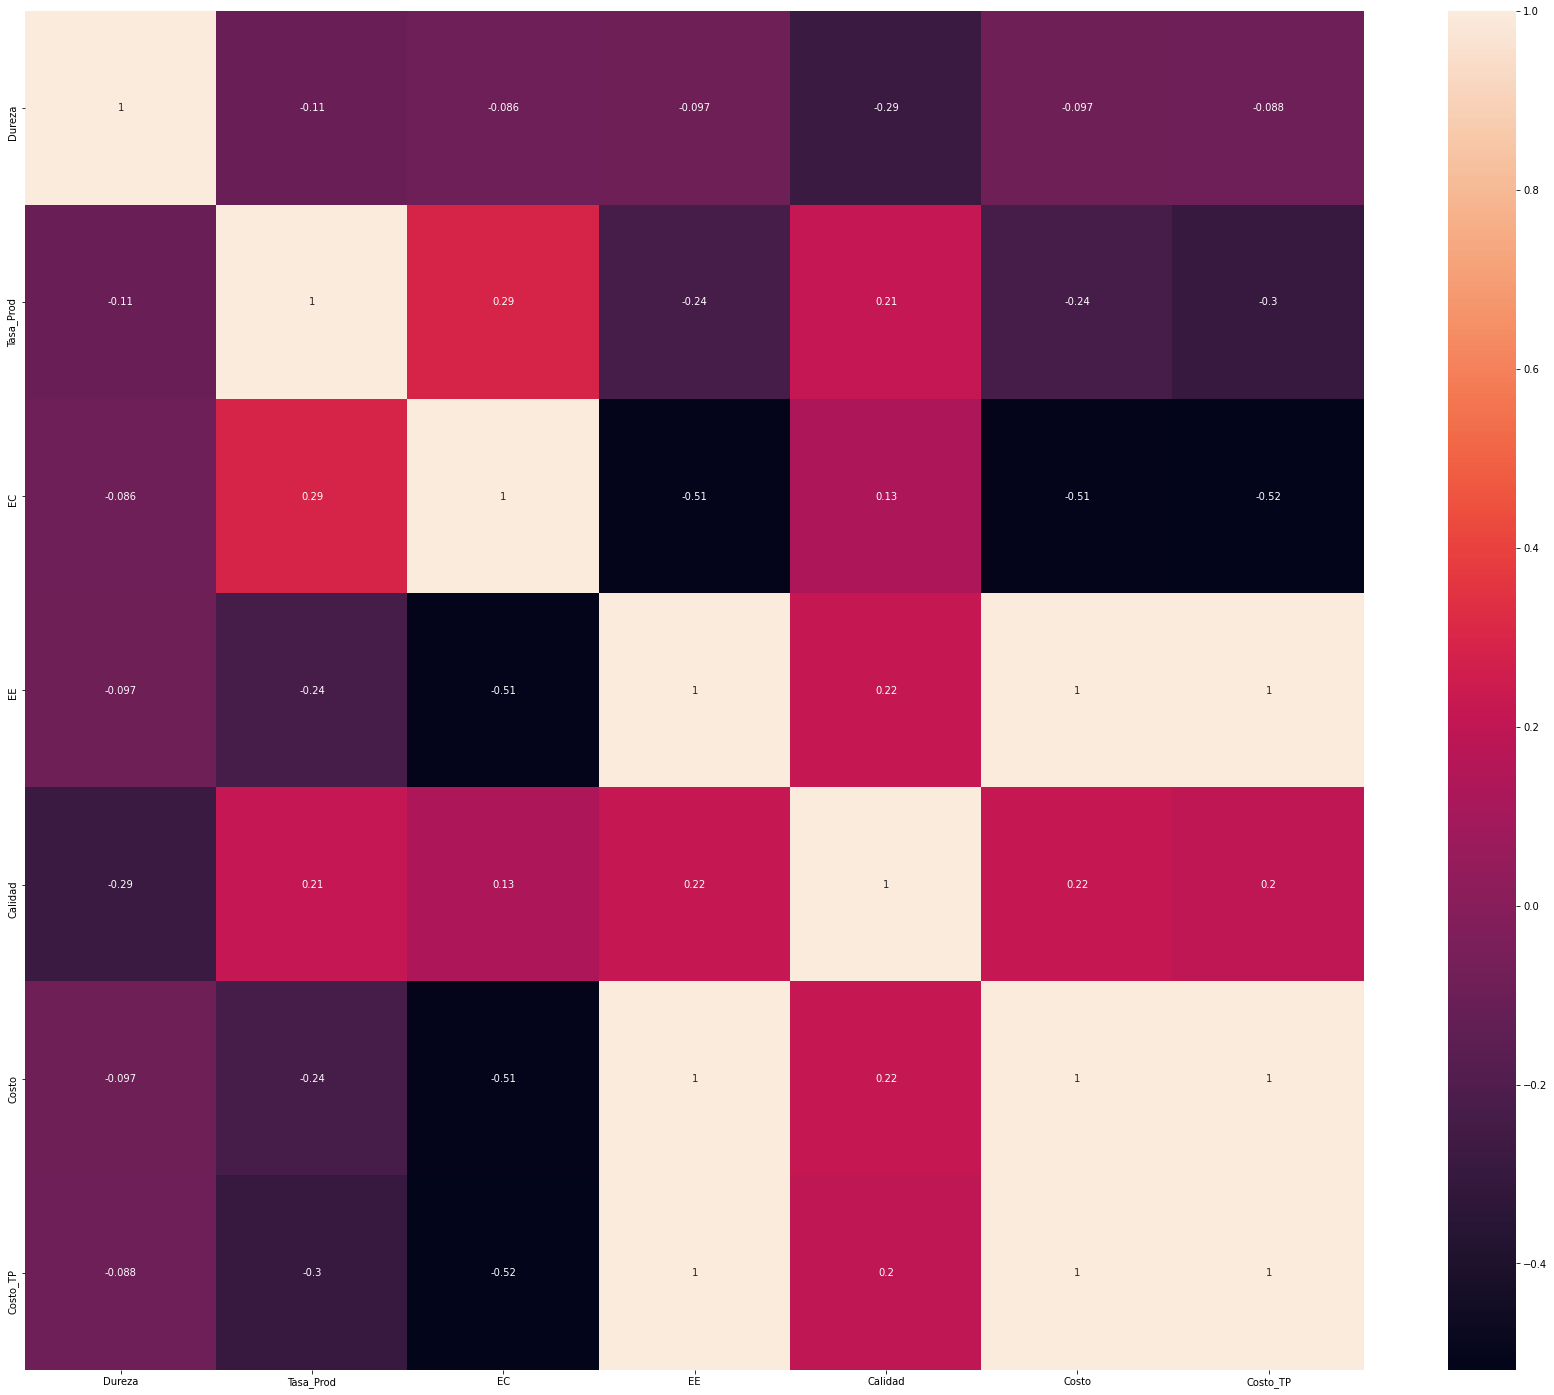

In [51]:
getHeatMap(cluster1, 'spearman')

De la tabla de dispersión y el mapa de calor podemos ver que la tasa de producción y la calidad muestran resultados distintos a los obtenidos de la tabla original, en este caso muestran una correlacióón más alta con el costo ponderado, a continuacióón se calcula el cambio que tuvieron en términos porcentuales todas las variables de la tabla. 

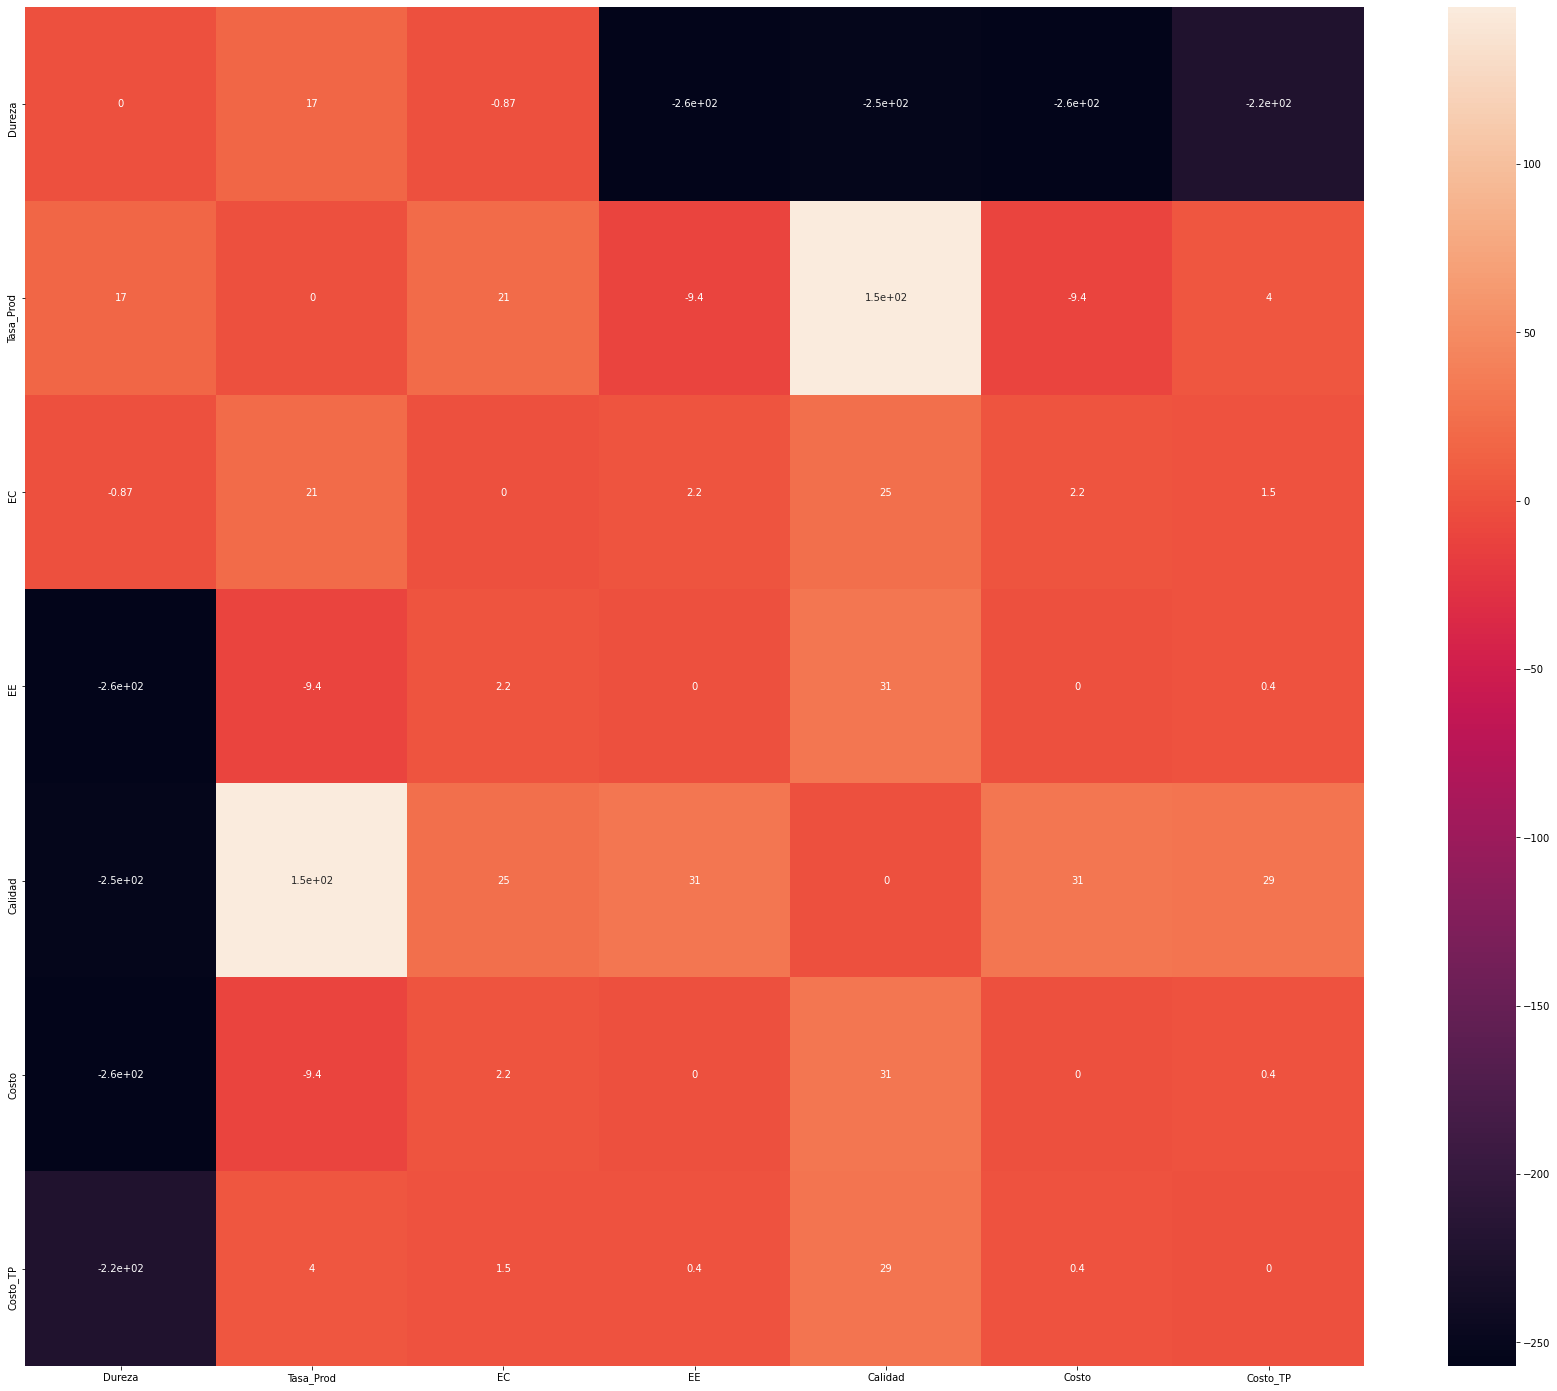

In [52]:
diferencia_porcentual_C1 = (cluster1.corr(method="spearman") - df.corr(method="spearman"))/df.corr(method="spearman").abs() * 100
getHeatMap(diferencia_porcentual_C1, '')

Presentamos a continuación los cambios más reelevantes para el análisis.
* **Energía Calórica**
  * Tasa de producción: +21%
  * Calidad: +25%
  * Dureza: -0.87%


* **Energía Eléctrica**
  * Tasa de producción: -9.4%
  * Calidad: +31%
  * Dureza: -260%


* **Costo por tasa de producción**
  * Tasa de producción: +4%
  * Calidad: +29%
  * Dureza: -202%

Por lo que podemos concluír que para este cluster, en su mayoría hubo un aumento en la correlación de sus variables independientes con las dependientes, por lo que fue beneficioso para el análisis obtener este cluster para la posterior modelación con regresión.

In [53]:
get3DChart(cluster1, 35, 1, 'Cluster 1 3D')

Archivo en: file:///content/cemexVenturesEnergyEfficiencyModelApp/research/3DCharts/Cluster 1 3D.html


### Cluster 2

In [54]:
cluster2 = df[y_hc == 1]
cluster2.describe()

Dureza    Tasa_Prod  ...        Costo     Costo_TP
count  1038.000000  1038.000000  ...  1038.000000  1038.000000
mean     -0.045016     0.703324  ...    -0.061587    -0.125383
std       0.812941     0.961070  ...     1.007883     0.999392
min      -2.246123    -2.543101  ...    -2.504670    -2.451745
25%      -0.552043     0.002099  ...    -0.667791    -0.730706
50%       0.012650     0.567700  ...     0.057207    -0.073239
75%       0.577343     1.529220  ...     0.678170     0.630270
max       2.271423     2.547300  ...     1.786799     1.778888

[8 rows x 7 columns]

#### Outliers

In [55]:
getCBoxPlots(cluster2, "C2")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las siguientes figuras, sólo la tasa de producción contiene outliers representativos, por lo que se removerán de la table de este cluster.

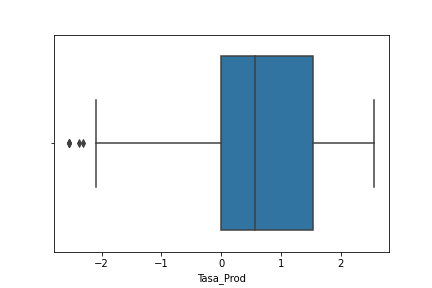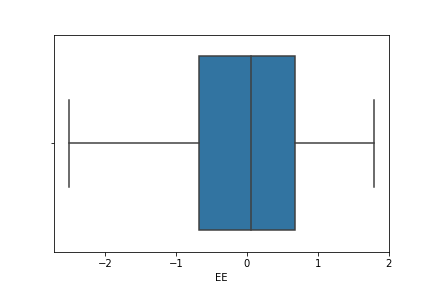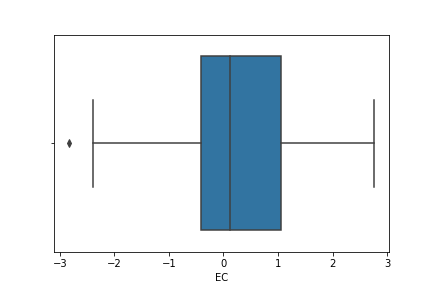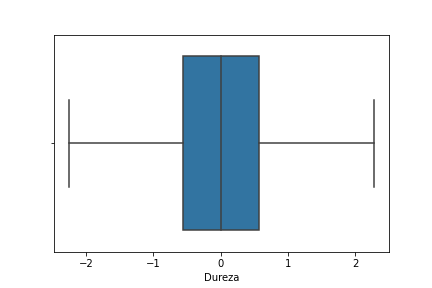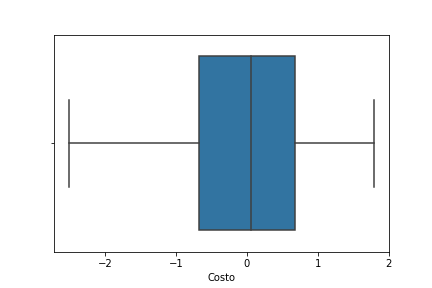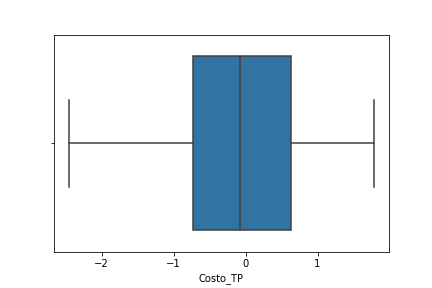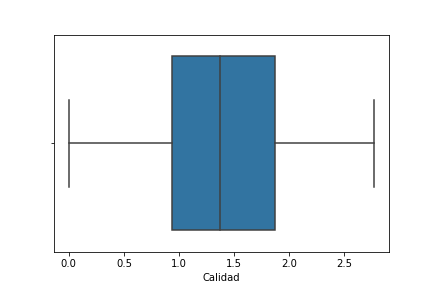

In [56]:
cluster2 = removeOutliers(["Tasa_Prod"], cluster2)

#### Análisis de Cluster y Correlación

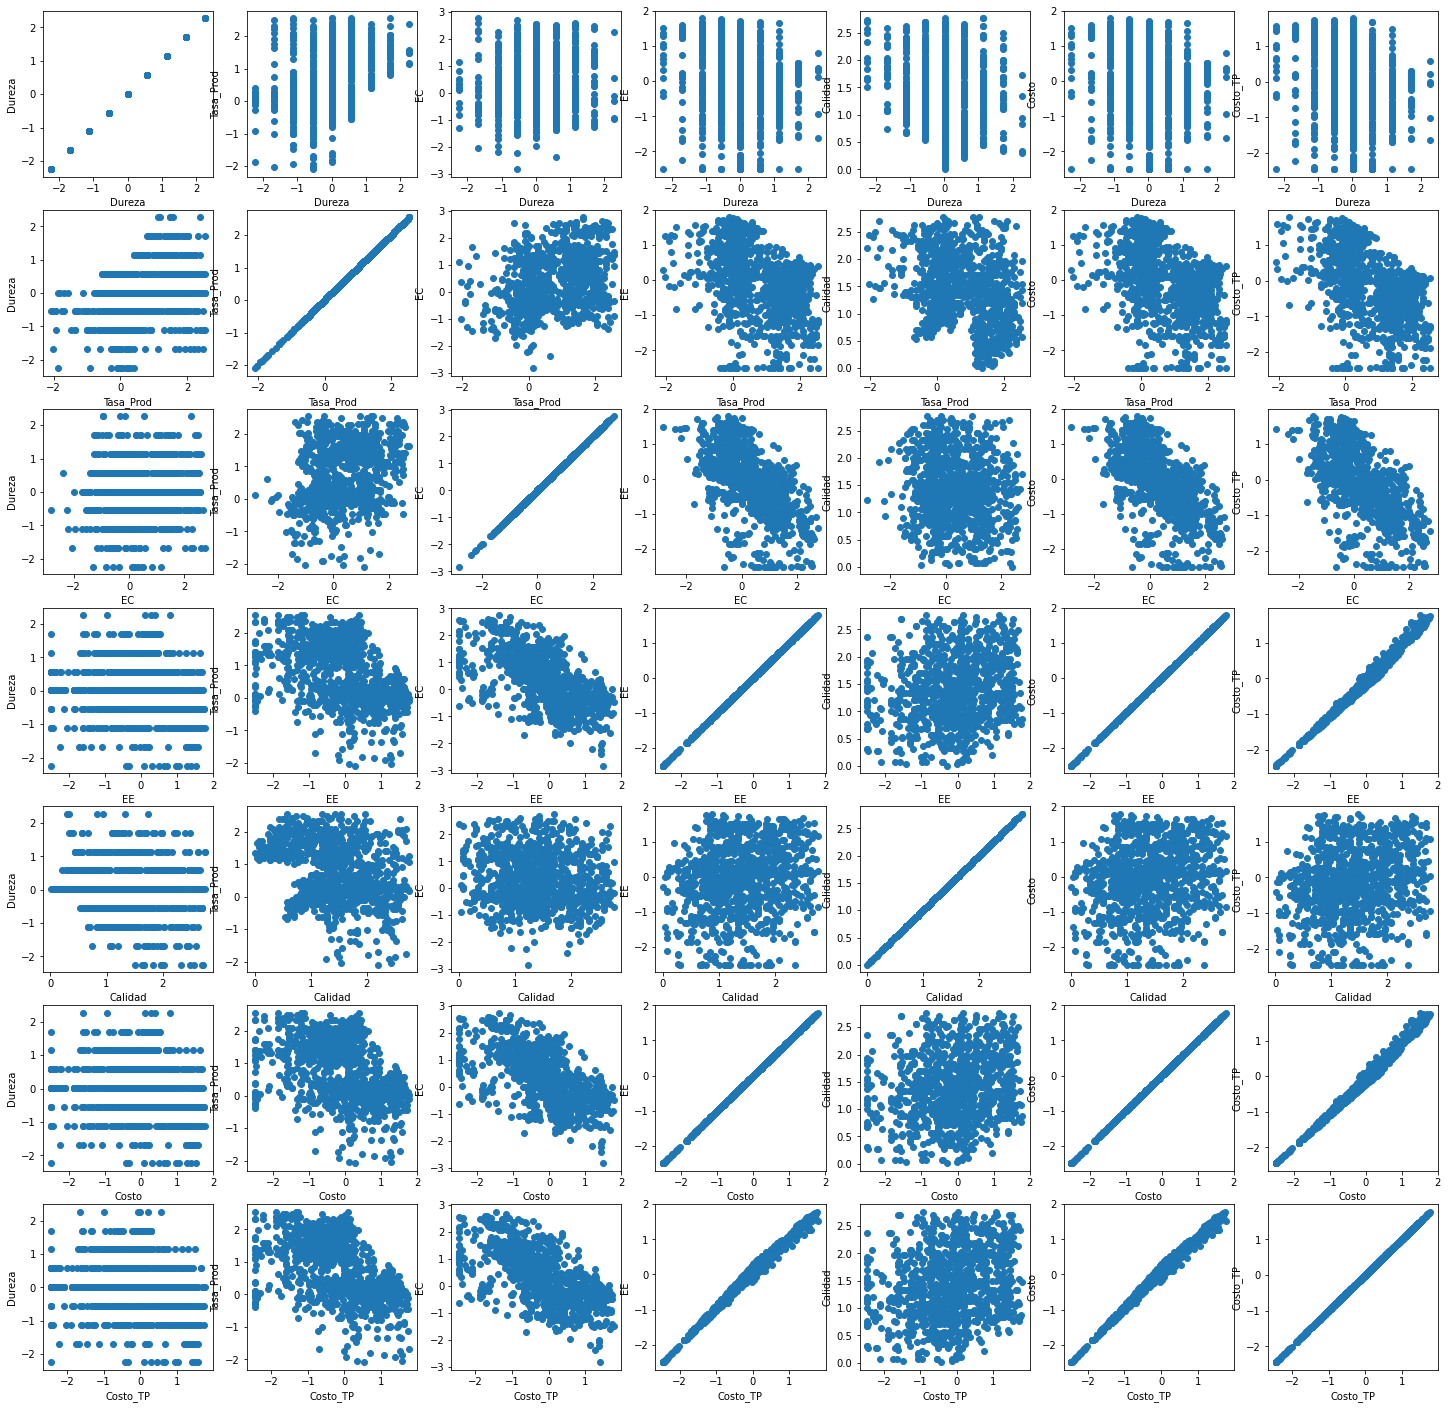

In [57]:
getTableOfScatters(cluster2)

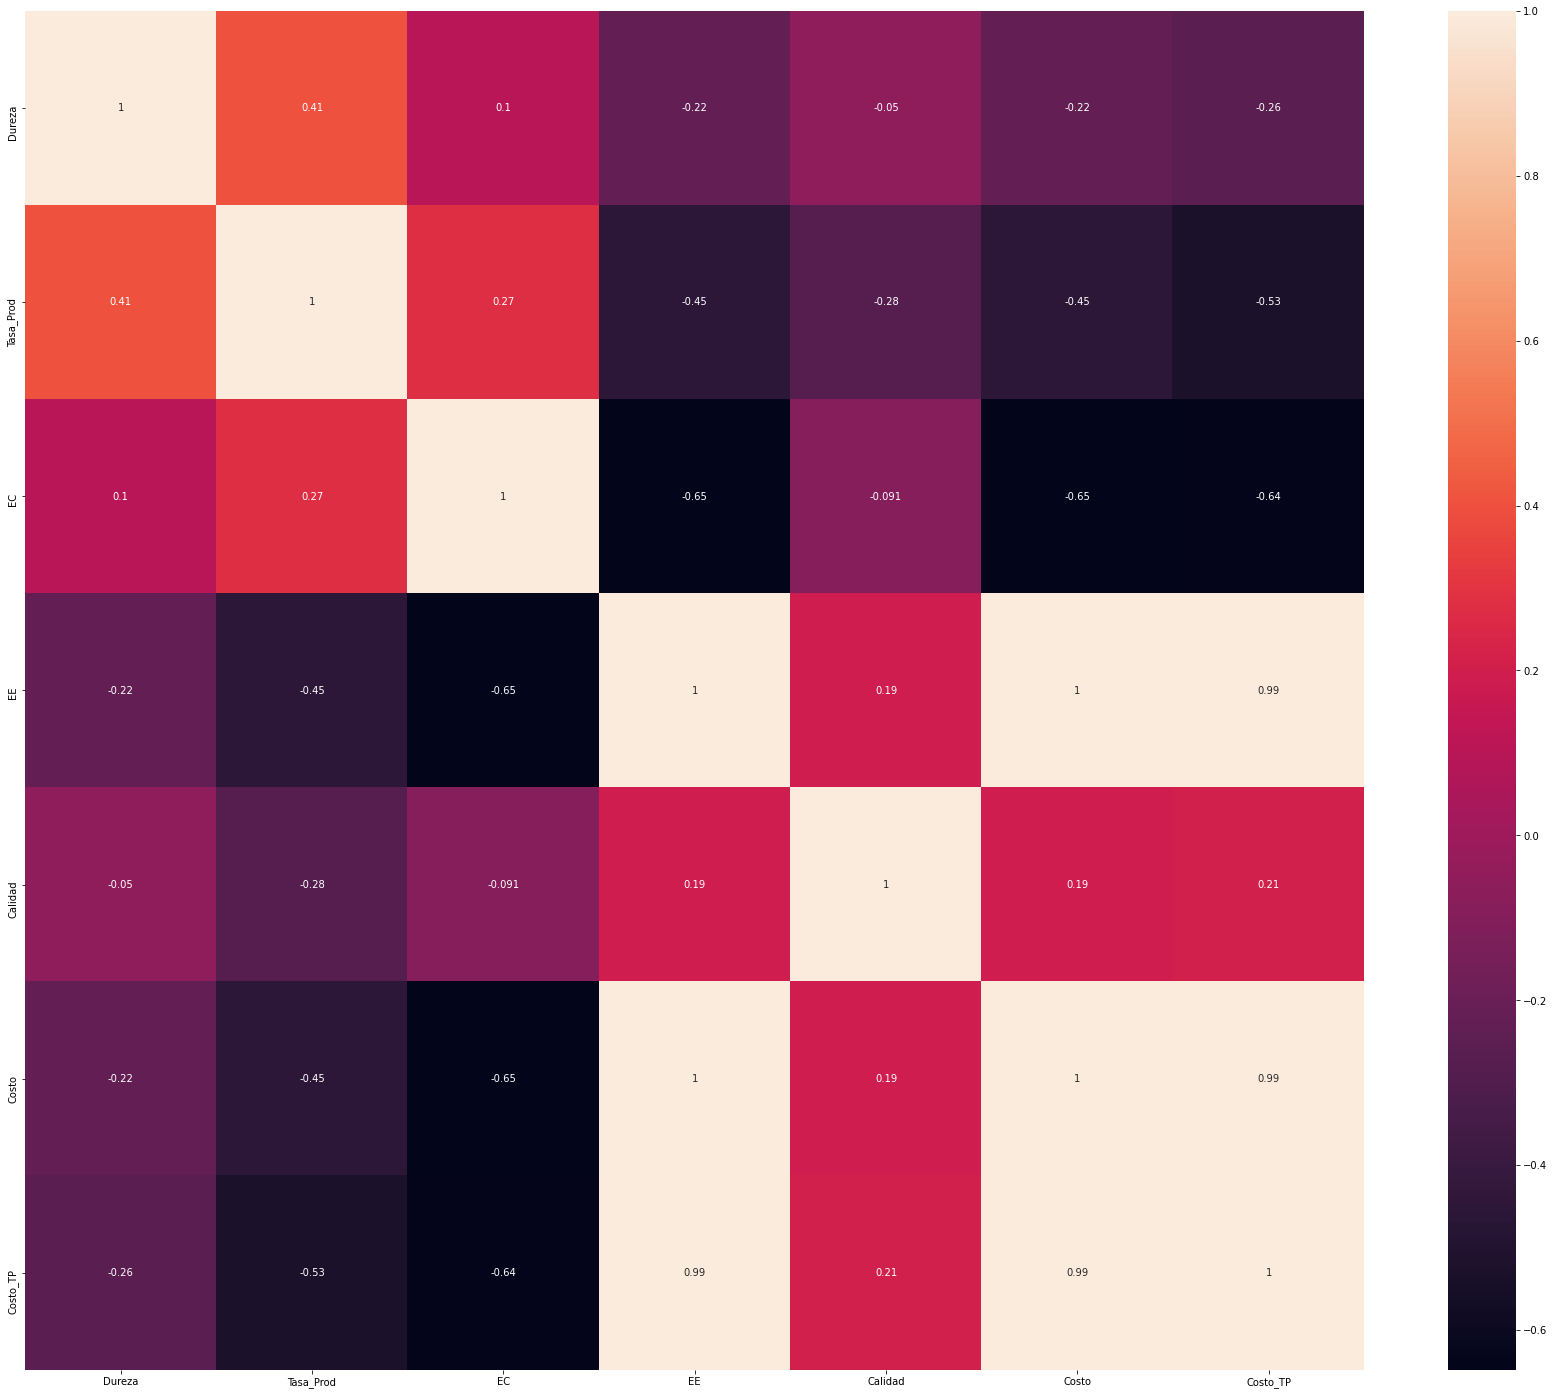

In [58]:
getHeatMap(cluster2, 'spearman')

Dadas las 2 figuras anteriores, vemos que tambiéén fue el caso de que hubo una "mejora" en cuanto a la dispersión de los datos, mostramos a continuación el cambio porcentual de las correlaciones del cluster 2.

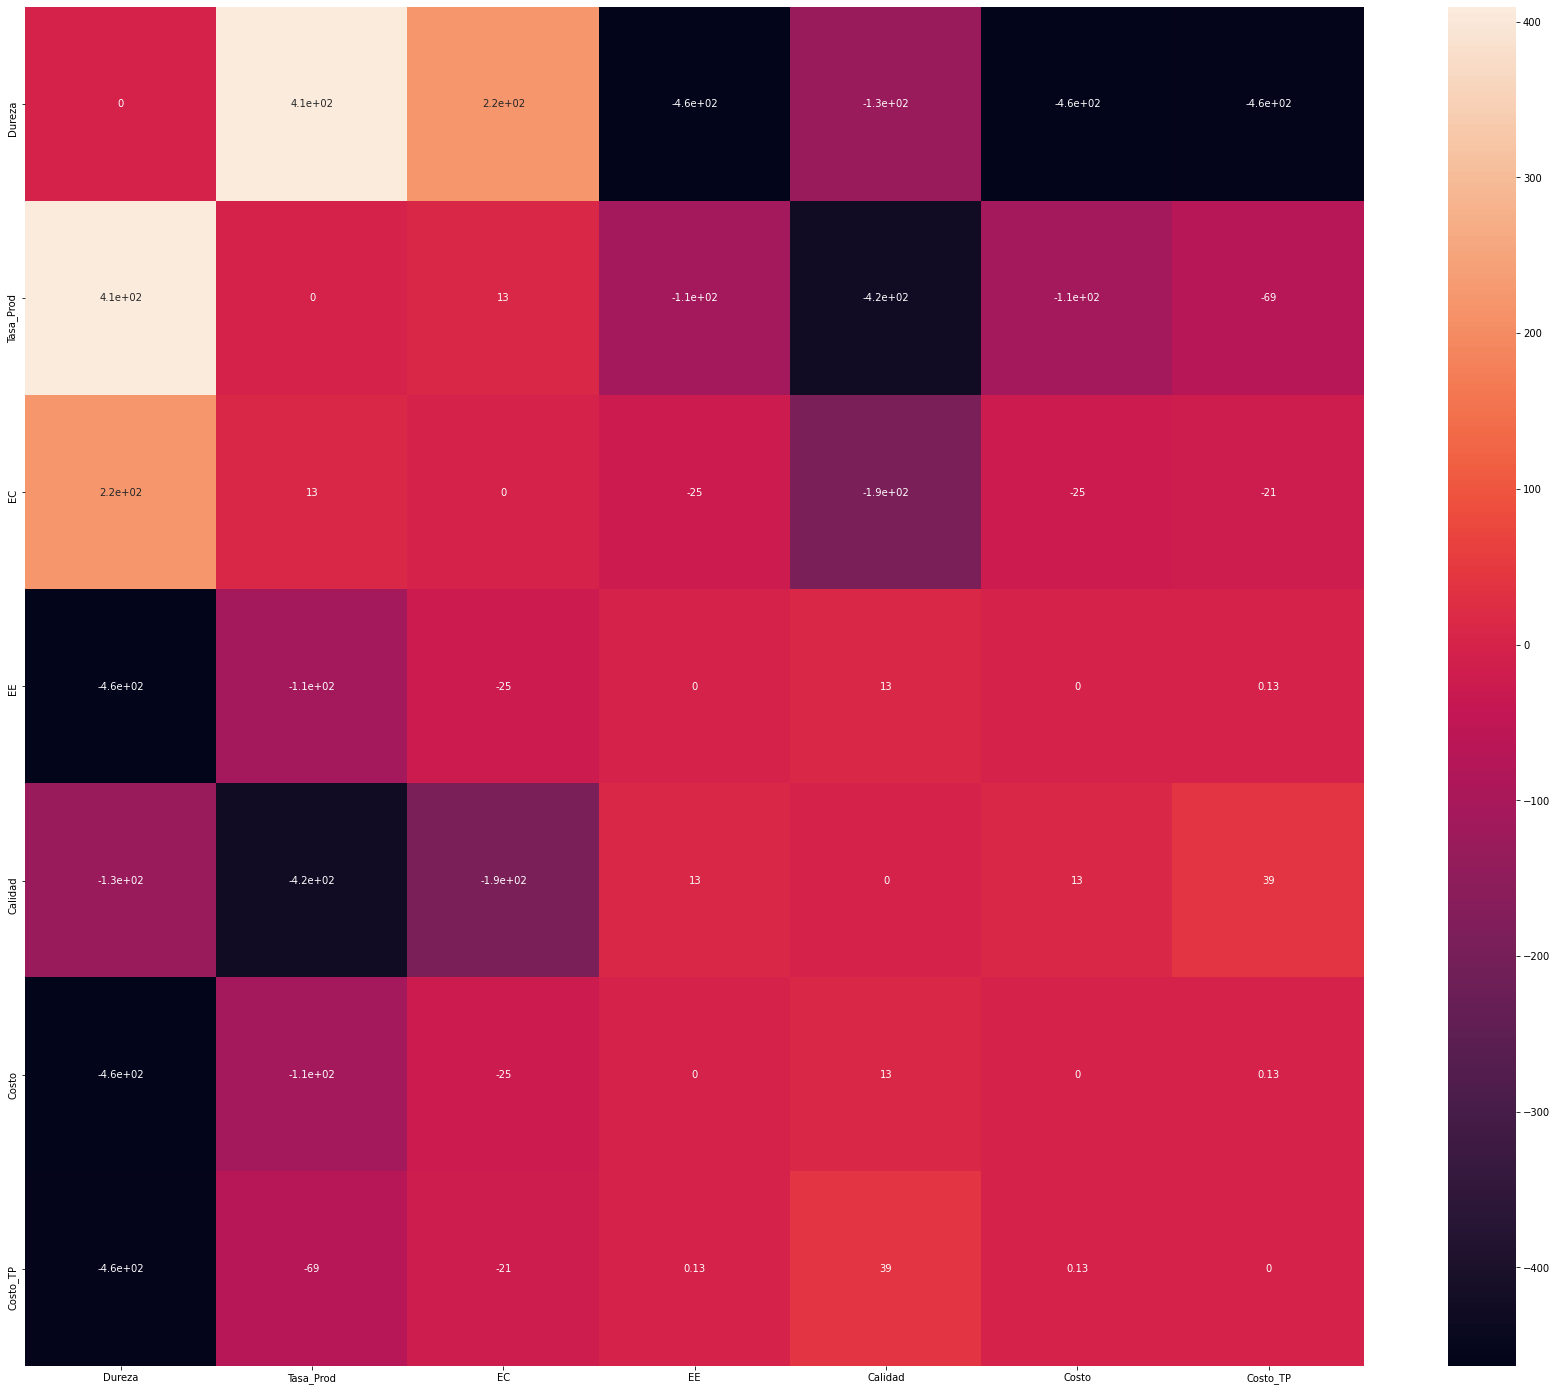

In [59]:
diferencia_porcentual_C2 = (cluster2.corr(method="spearman") - df.corr(method="spearman"))/df.corr(method="spearman").abs() * 100
getHeatMap(diferencia_porcentual_C2, '')

Dada la clusterización, los cambios más reelevantes de la correlacion de las variables son los siguientes.

* **Energía Calórica**
  * Tasa de producción: +13%
  * Calidad: -190%
  * Dureza: +202%


* **Energía Eléctrica**
  * Tasa de producción: -110%
  * Calidad: +13%
  * Dureza: -460%


* **Costo por tasa de producción**
  * Tasa de producción: -69%
  * Calidad: +39%
  * Dureza: -460%

In [60]:
get3DChart(cluster2, 35, 1 , 'Cluster 2 3D')

Archivo en: file:///content/cemexVenturesEnergyEfficiencyModelApp/research/3DCharts/Cluster 2 3D.html


### Cluster 3

In [61]:
cluster3 = df[y_hc == 2]
cluster3.describe()

Dureza    Tasa_Prod  ...        Costo     Costo_TP
count  1513.000000  1513.000000  ...  1513.000000  1513.000000
mean      0.249276    -1.215941  ...     0.054380     0.179422
std       0.805739     0.570384  ...     0.966974     0.991264
min      -2.246123    -2.599661  ...    -2.504670    -2.451745
25%      -0.552043    -1.581581  ...    -0.527993    -0.407795
50%       0.012650    -1.129101  ...     0.135234     0.270194
75%       0.577343    -0.789741  ...     0.785457     0.915782
max       2.271423    -0.054461  ...     1.981866     2.427830

[8 rows x 7 columns]

#### Outliers

In [62]:
getCBoxPlots(cluster3, "C3")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

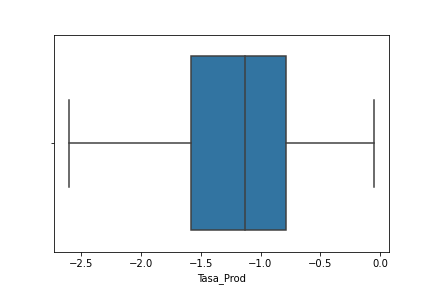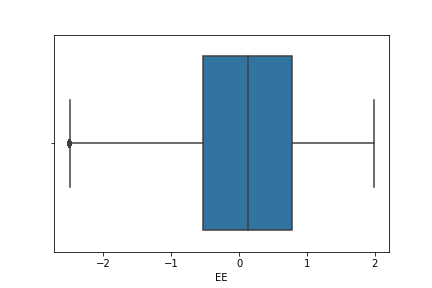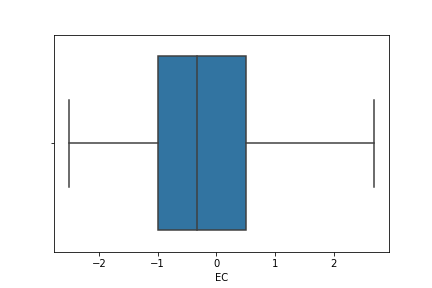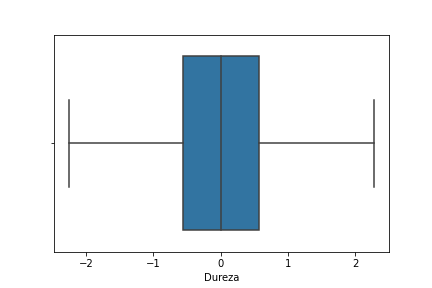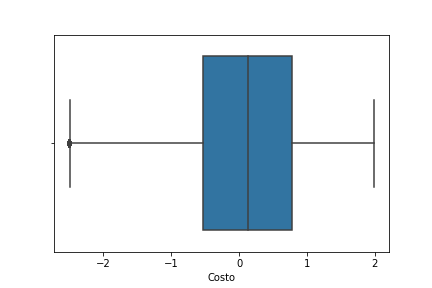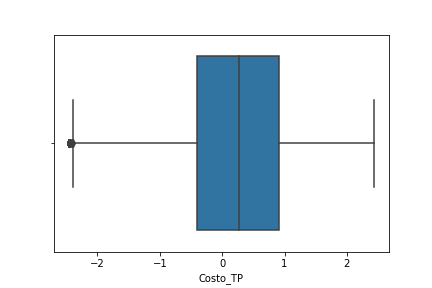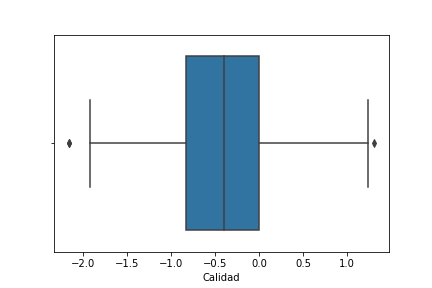

In [64]:
cluster3 = removeOutliers(["Calidad", "Costo_TP"], cluster3)

In [65]:
cluster3.shape[0]

1467

#### Análisis de Cluster y Correlación

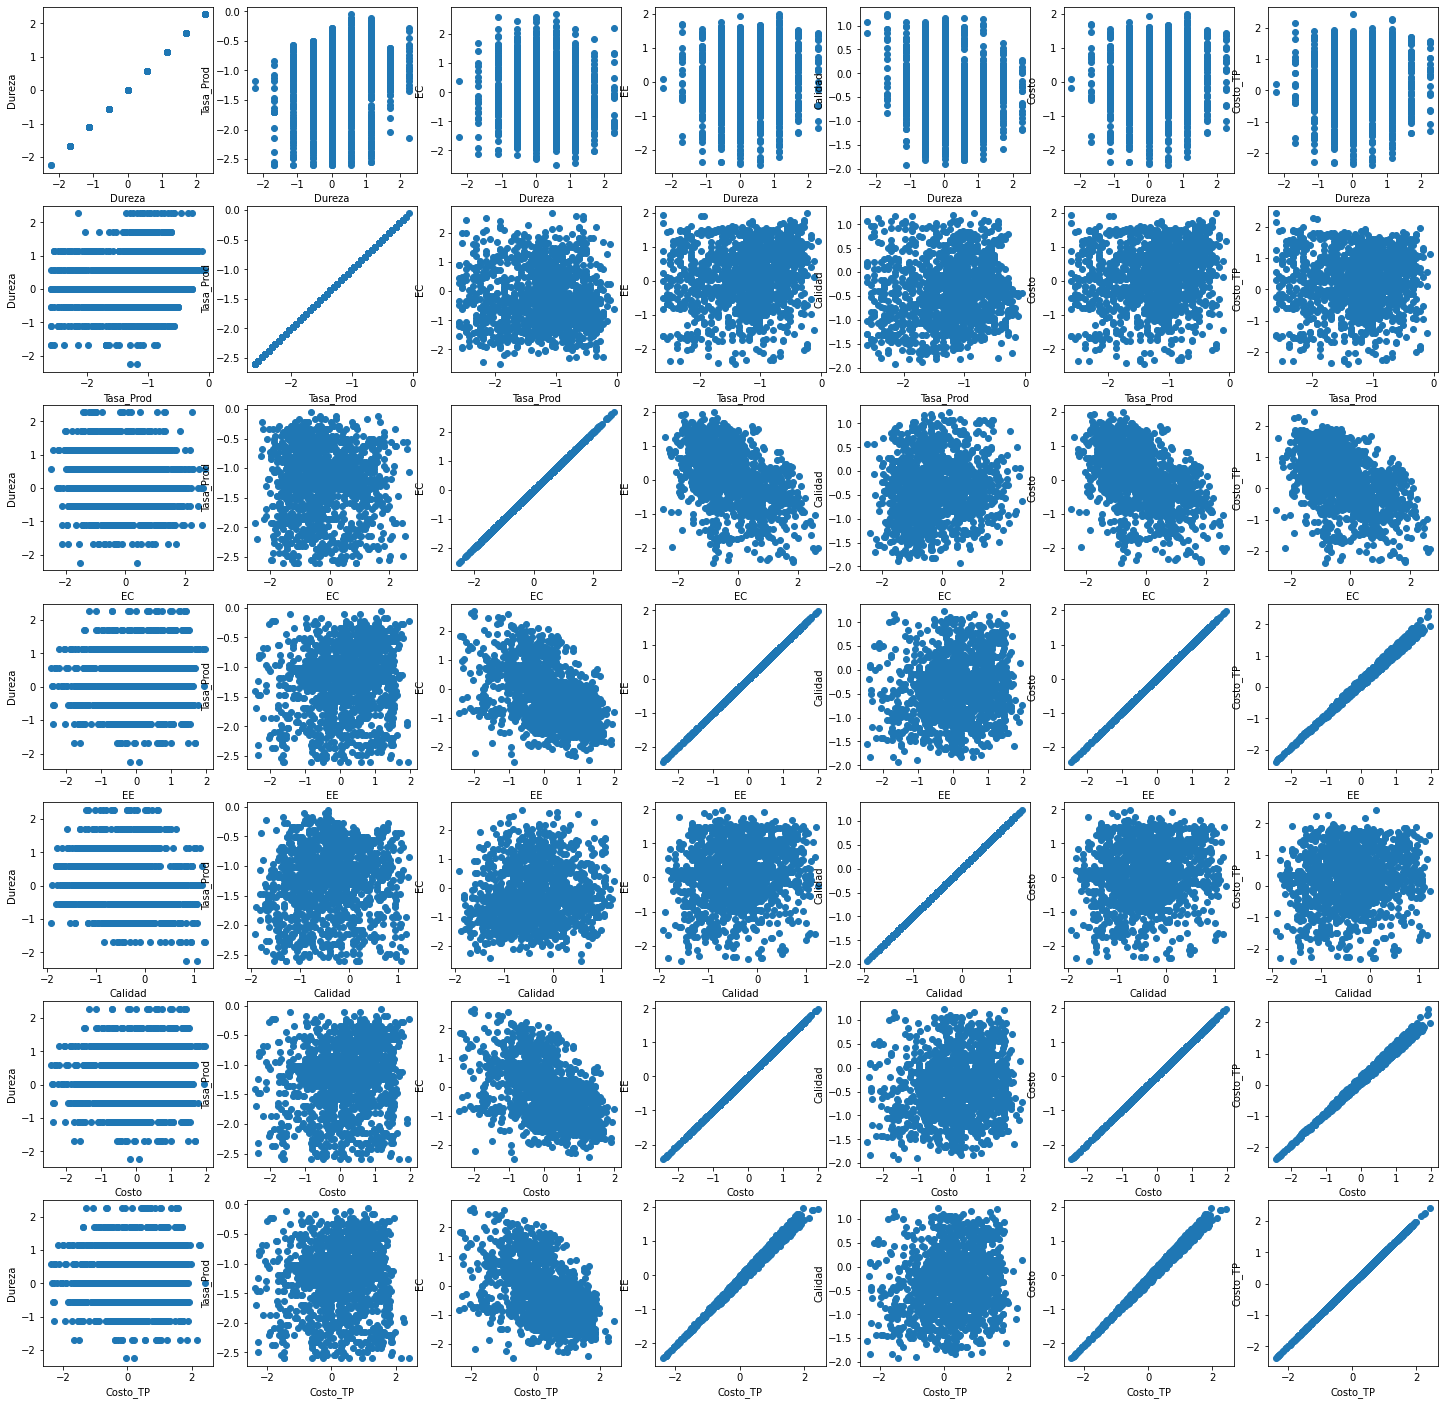

In [66]:
getTableOfScatters(cluster3)

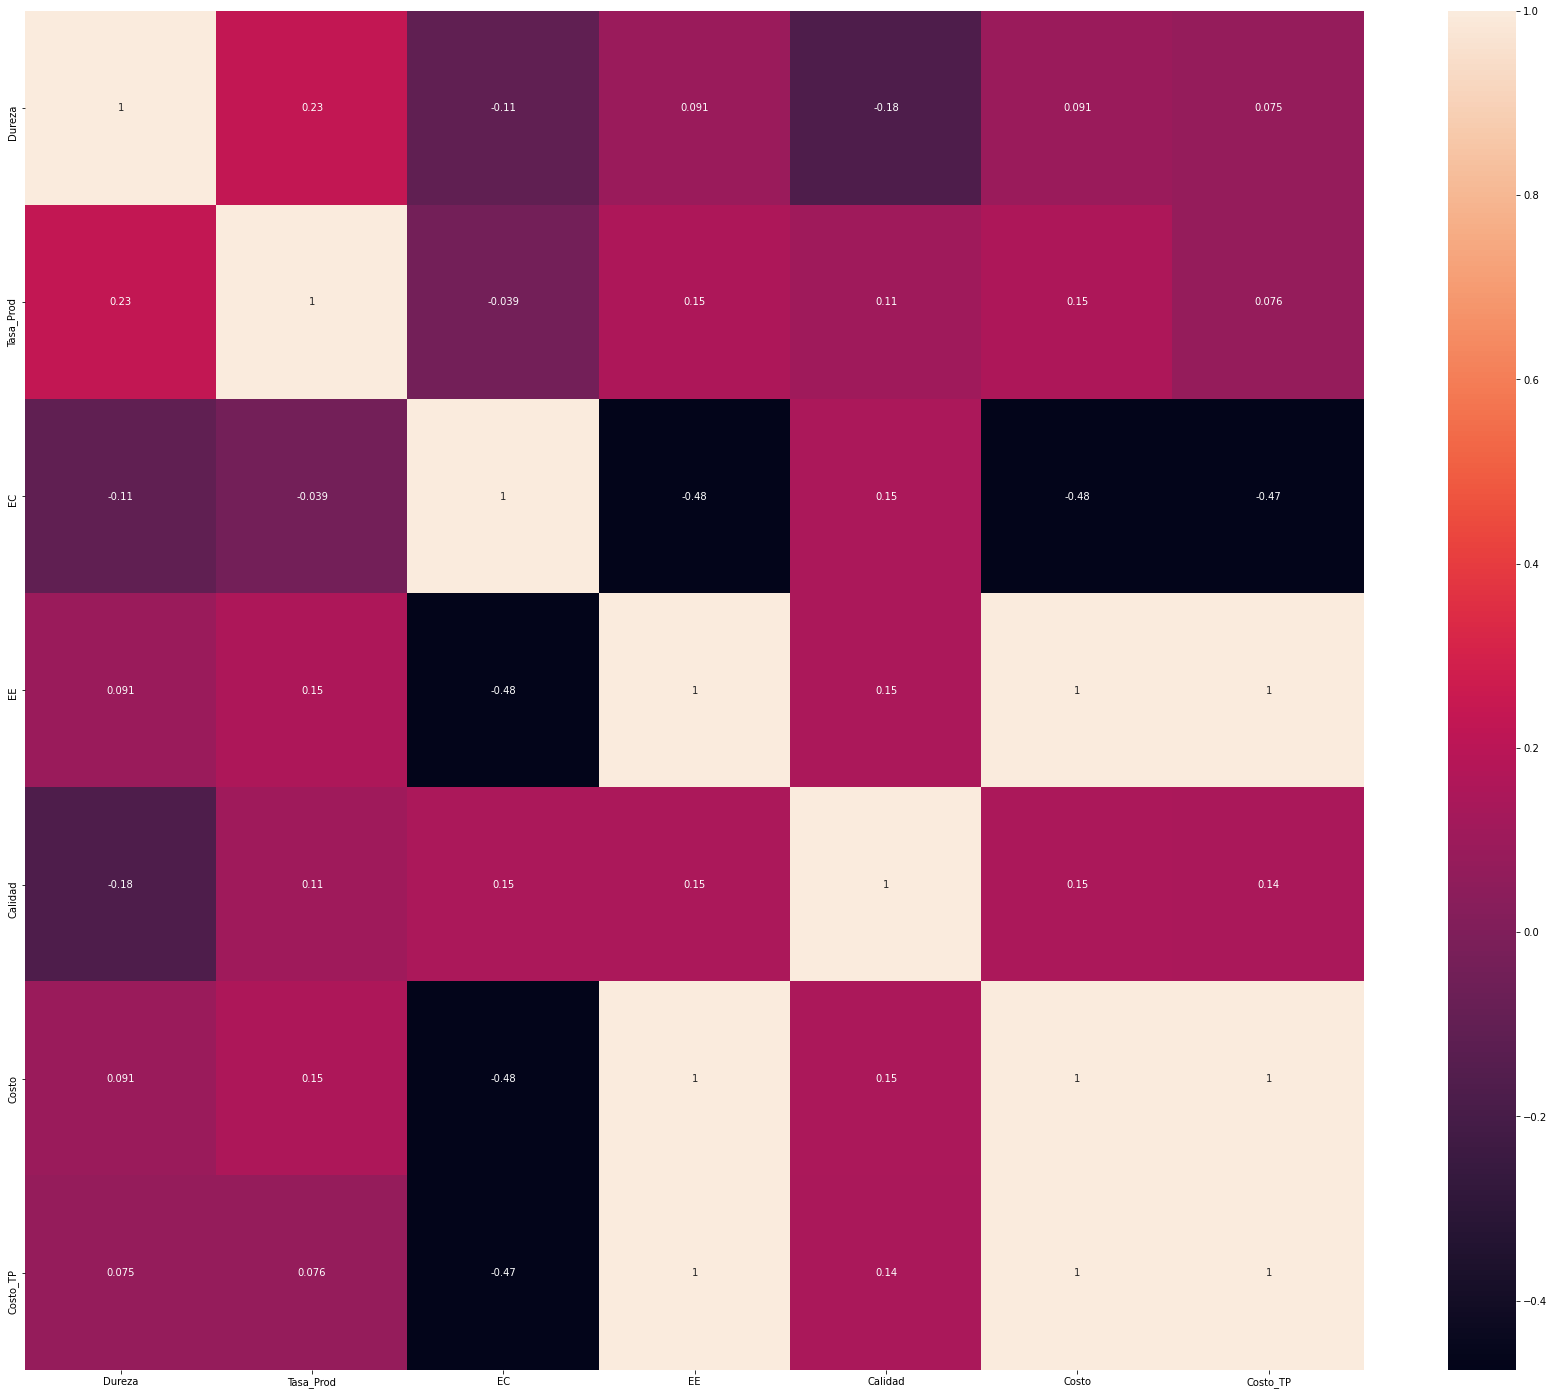

In [67]:
getHeatMap(cluster3, 'spearman')

Así como en los clusters anteriores se analizará la variacióón porcentual del cambio de la correlación para validar o denegar nuestra tesis. 

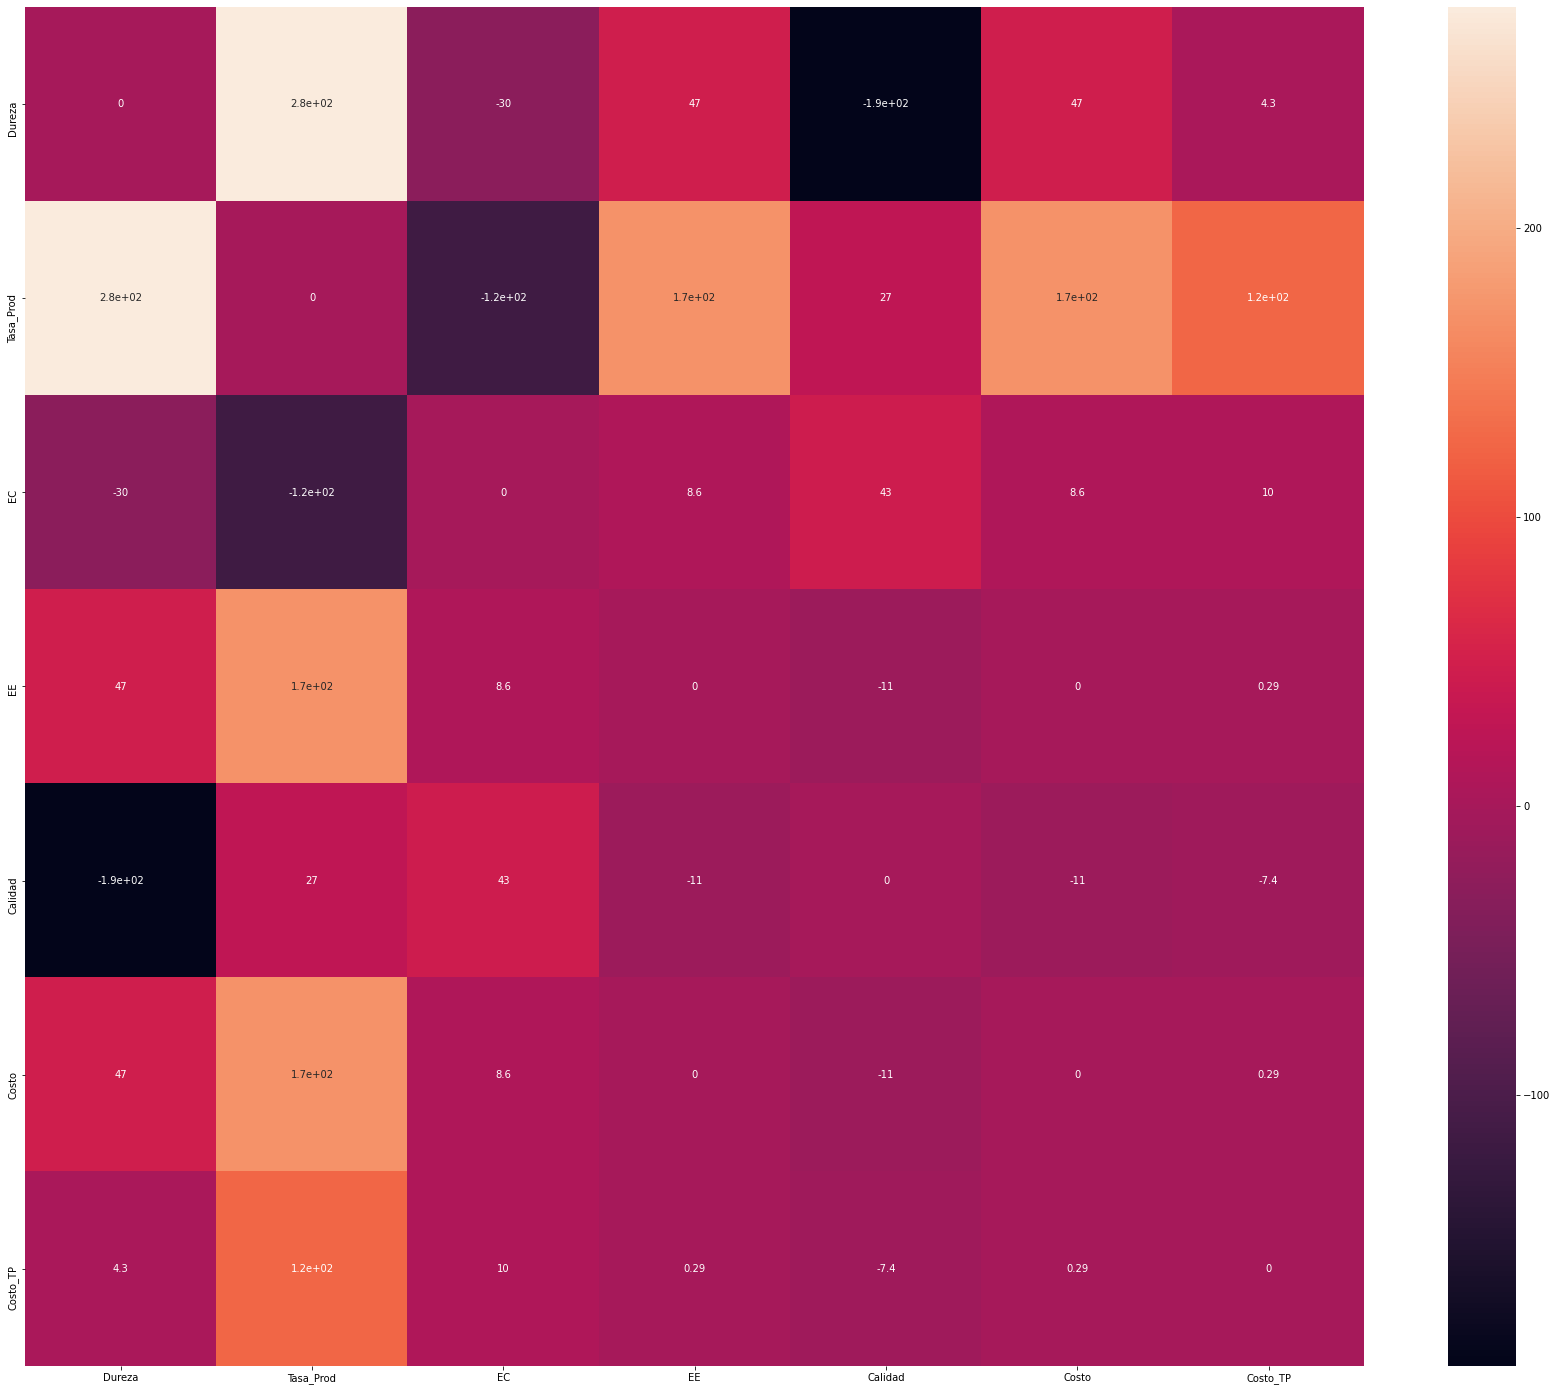

In [68]:
diferencia_porcentual_C3 = (cluster3.corr(method="spearman") - df.corr(method="spearman"))/df.corr(method="spearman").abs() * 100
getHeatMap(diferencia_porcentual_C3, '')

Los cambios más reelevates son:

* **Energía Calórica**
  * Tasa de producción: -120%
  * Calidad: +43%
  * Dureza: -30%


* **Energía Eléctrica**
  * Tasa de producción: +170%
  * Calidad: -11%
  * Dureza: +47%


* **Costo por tasa de producción**
  * Tasa de producción: +120%
  * Calidad: -7.4%
  * Dureza: +4.3%

In [70]:
get3DChart(cluster3, 35, 1 , 'Cluster 3 3D')

Archivo en: file:///content/cemexVenturesEnergyEfficiencyModelApp/research/3DCharts/Cluster 3 3D.html


### Cluster 4

In [71]:
cluster4 = df[y_hc == 3]
cluster4.describe()

Dureza    Tasa_Prod  ...        Costo     Costo_TP
count  1556.000000  1556.000000  ...  1556.000000  1556.000000
mean      0.489155     0.498126  ...    -0.094717    -0.145557
std       0.448074     0.641197  ...     0.967990     0.943873
min       0.012650    -0.902861  ...    -2.504670    -2.451745
25%       0.012650     0.002099  ...    -0.658037    -0.696954
50%       0.577343     0.398020  ...     0.070212    -0.003543
75%       0.577343     0.850500  ...     0.616399     0.542535
max       2.271423     2.547300  ...     1.799804     1.822424

[8 rows x 7 columns]

#### Outliers

In [72]:
getCBoxPlots(cluster4, "C4")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las grááficas siguientes podemos resaltar a la tasa de producción junto con la dureza y la calidad.

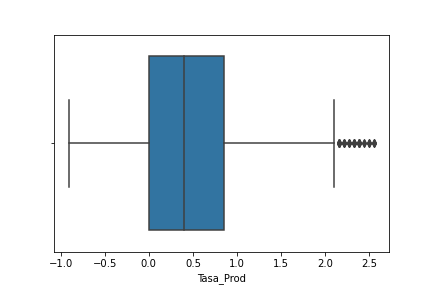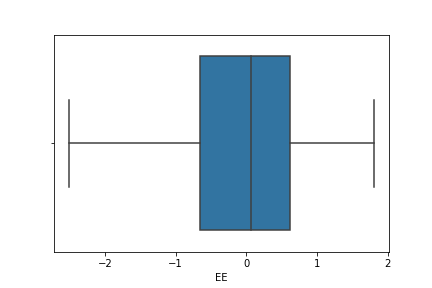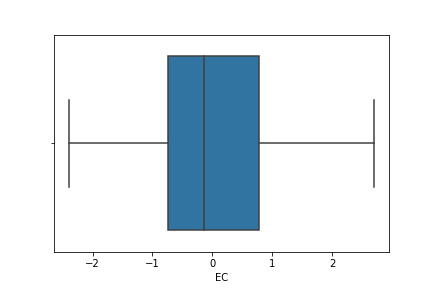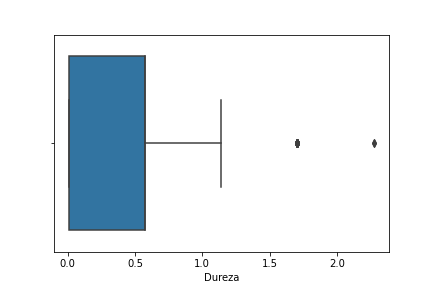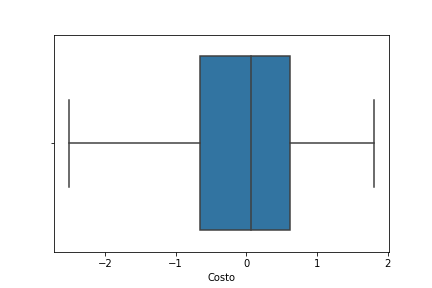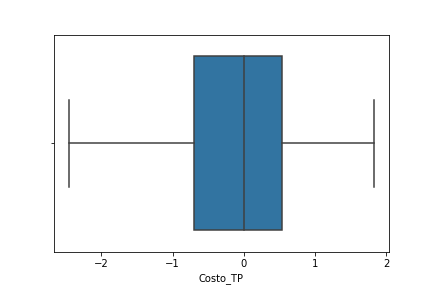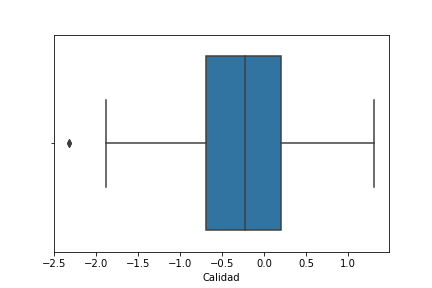

In [73]:
cluster4 = removeOutliers(["Tasa_Prod", "Dureza"], cluster4)

In [74]:
cluster4.describe()

Dureza    Tasa_Prod  ...        Costo     Costo_TP
count  1492.000000  1492.000000  ...  1492.000000  1492.000000
mean      0.461528     0.452153  ...    -0.079095    -0.127449
std       0.416019     0.582205  ...     0.962883     0.938154
min       0.012650    -0.902861  ...    -2.504670    -2.451745
25%       0.012650     0.002099  ...    -0.609271    -0.673927
50%       0.577343     0.341460  ...     0.083216     0.011538
75%       0.577343     0.793940  ...     0.632654     0.563761
max       1.142036     2.094820  ...     1.799804     1.822424

[8 rows x 7 columns]

In [75]:
getCBoxPlots(cluster4, "C4-1")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

Una vez eliminados los ouliers podemos ver que ahora existen más outliers, esto se debe al recorrido de nuestras medidas de posición como lo son los cuartiles, es por esto que permitiremos ese grado de error lo que en realidad no representa un cesgo importante en los datos.

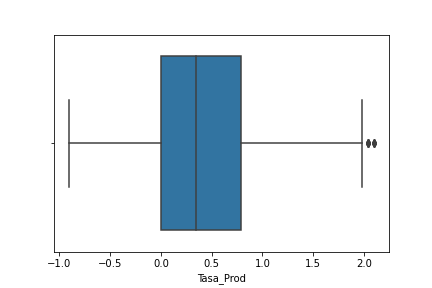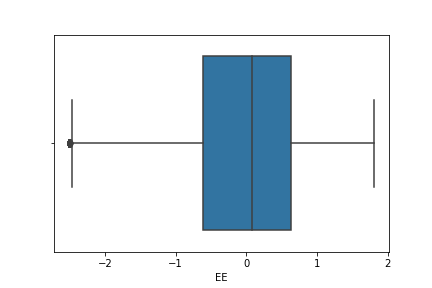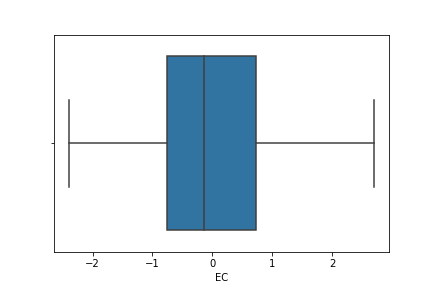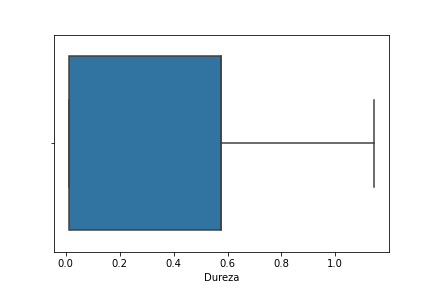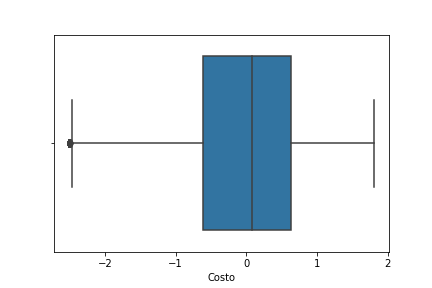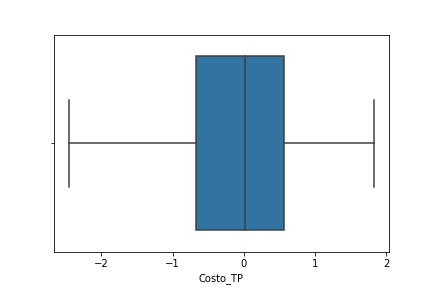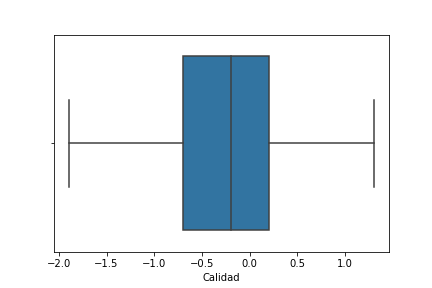

#### Análisis de Cluster y Correlación

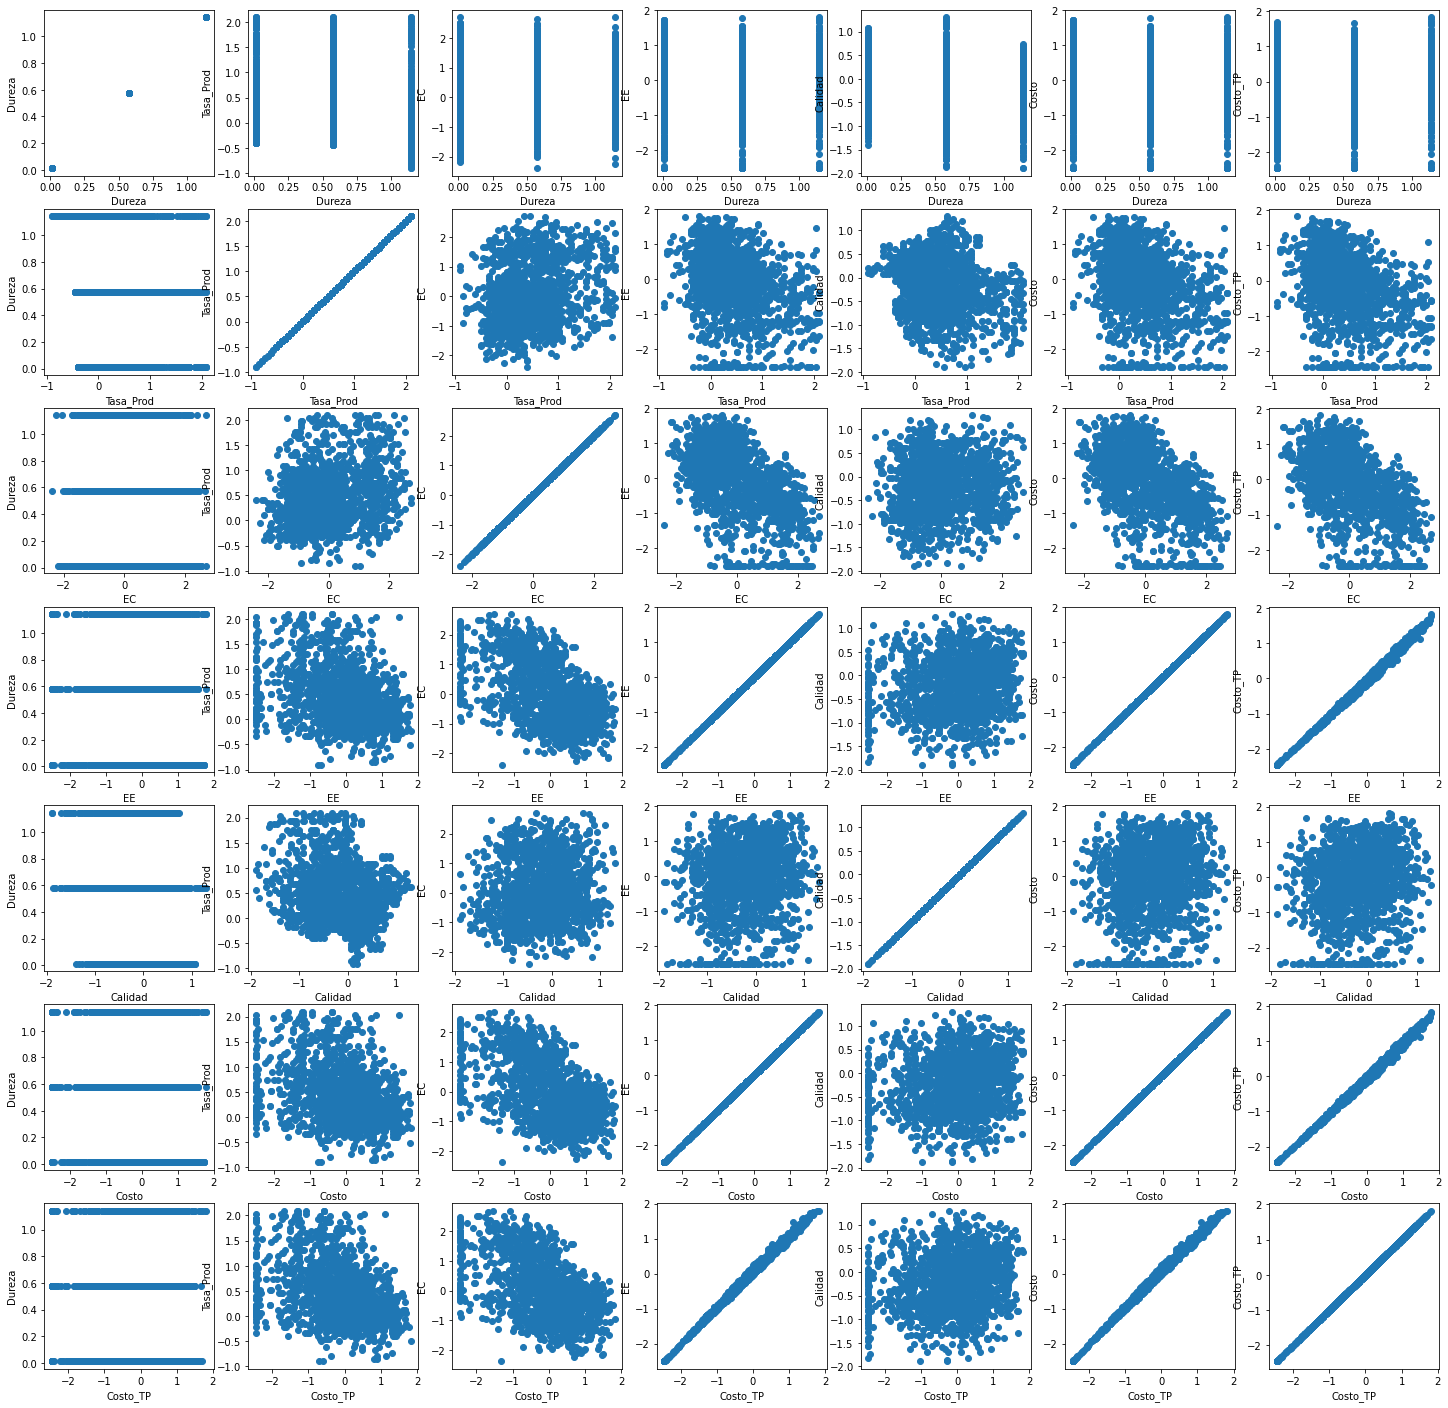

In [76]:
getTableOfScatters(cluster4)

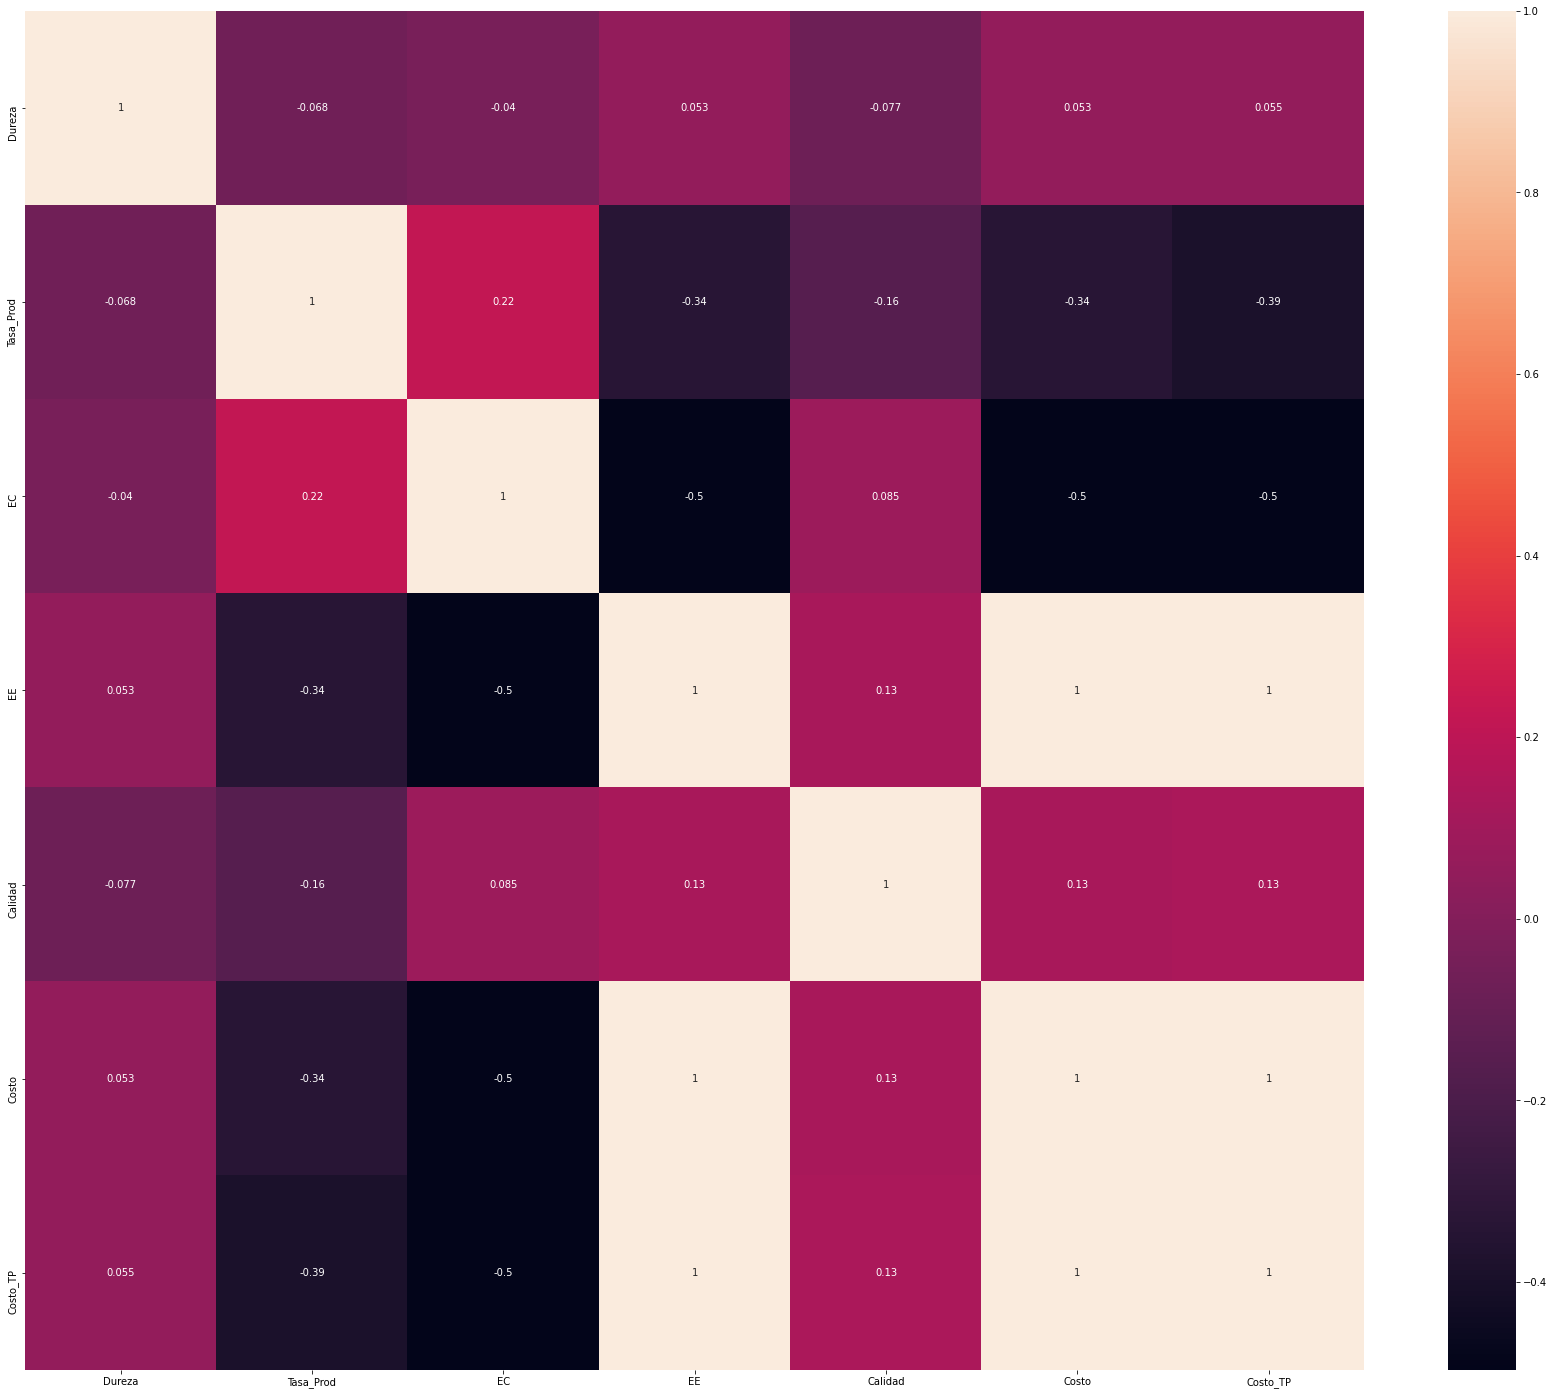

In [77]:
getHeatMap(cluster4, 'spearman')

Hay que destacar que la figura anterior es la que mayores correlaciones ha presentado el análisis hasta ahora. Se analizan los resultados a continuación.

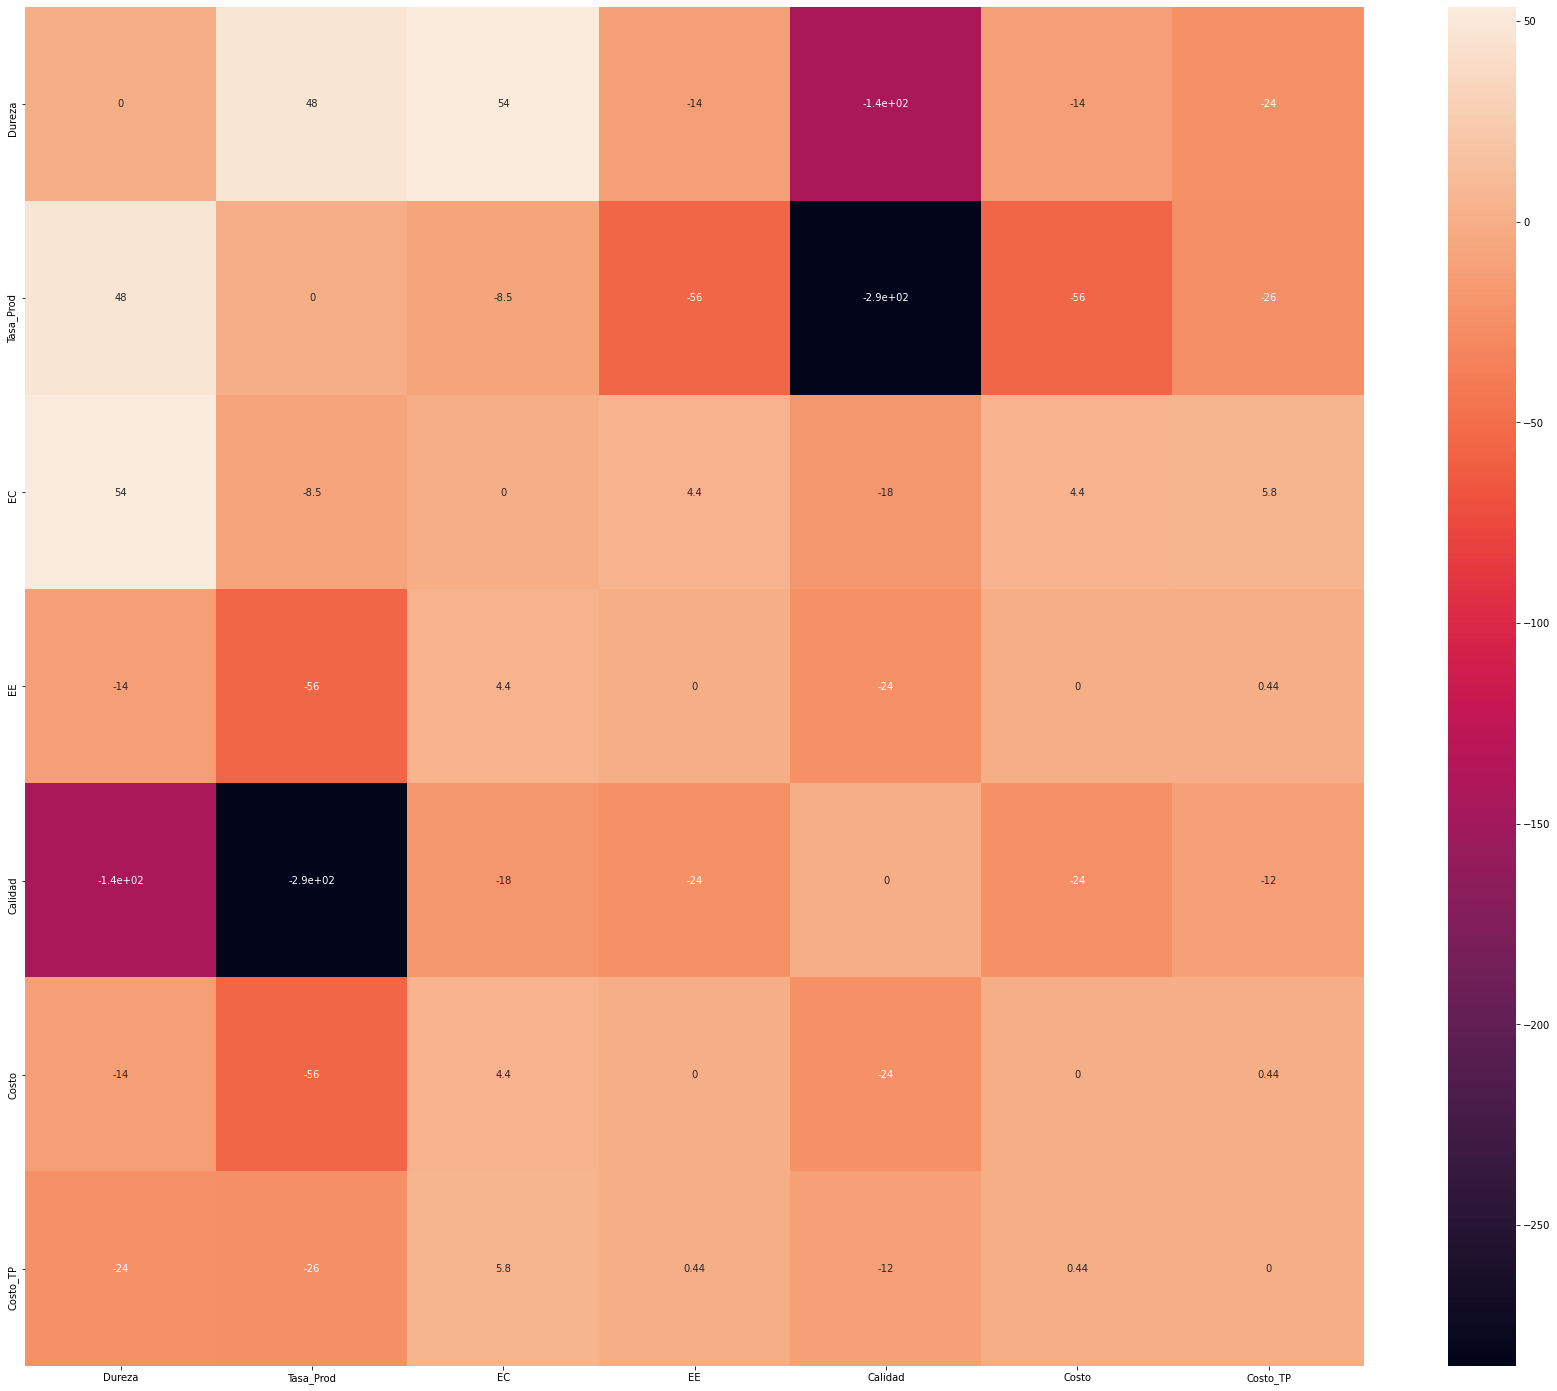

In [78]:
diferencia_porcentual_C4 = (cluster4.corr(method="spearman") - df.corr(method="spearman"))/df.corr(method="spearman").abs() * 100
getHeatMap(diferencia_porcentual_C4, '')

Entre los cambios más reelevates se encuentran:

* **Energía Calórica**
  * Tasa de producción: -8.5%
  * Calidad: -1.8%
  * Dureza: +54%


* **Energía Eléctrica**
  * Tasa de producción: -56%
  * Calidad: -24%
  * Dureza: -14%


* **Costo por tasa de producción**
  * Tasa de producción: -26%
  * Calidad: -12%
  * Dureza: -24%

Hay que destacar que a pesar de tener correlaciones más altas que las demás figuras, el cambio porcentual del cluster con las variables importantes para el análisis disminuyó en su mayoría.

In [80]:
get3DChart(cluster4, 35, 1 , 'Cluster 4 3D')

Archivo en: file:///content/cemexVenturesEnergyEfficiencyModelApp/research/3DCharts/Cluster 4 3D.html


### Cluster 5

In [86]:
cluster5 = df[y_hc == 4]
cluster5.describe()

Dureza   Tasa_Prod          EC  ...     Calidad       Costo    Costo_TP
count  973.000000  973.000000  973.000000  ...  973.000000  973.000000  973.000000
mean     1.306859   -0.444219   -0.163326  ...    0.957583    0.361536    0.397538
std      0.598292    0.652303    0.848926  ...    0.762704    0.889014    0.889608
min      0.012650   -2.543101   -2.714233  ...   -1.126882   -2.504670   -2.451745
25%      0.577343   -0.959421   -0.726344  ...    0.436100   -0.059833   -0.038204
50%      1.142036   -0.393821   -0.286715  ...    0.934924    0.460345    0.532486
75%      1.706730    0.058659    0.248486  ...    1.467003    1.032541    1.042282
max      2.271423    1.020180    2.580433  ...    2.763945    1.721777    1.945012

[8 rows x 7 columns]

#### Outliers

In [87]:
getCBoxPlots(cluster5, "C5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

De las gráficas de caja podemos destacar a la Energía Eléctrica, Calórica el costo, el costo ponderado y la calidad. 

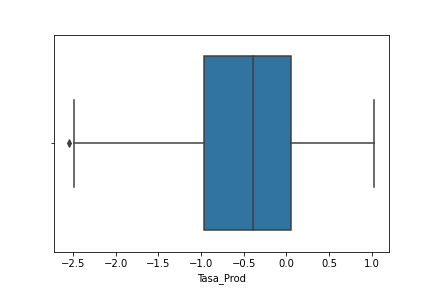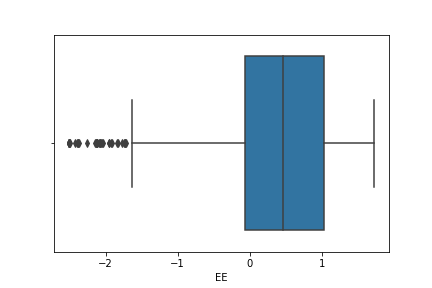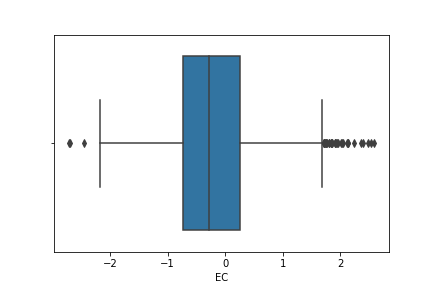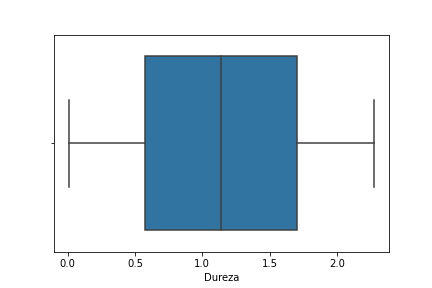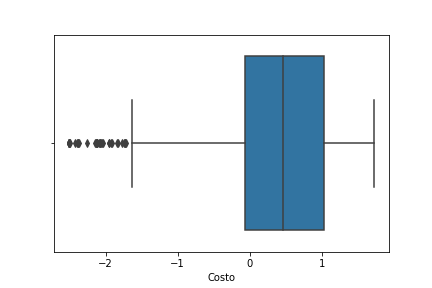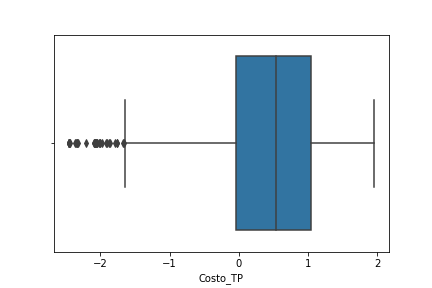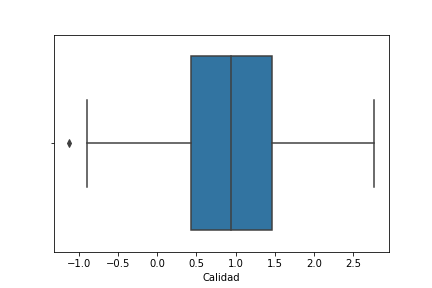

Para abordar los ouliers anteriores se van a remover los boxplots de Costo y de calidad, ya que lo mas probable es que en los outliers de costo vengan incluídos los de las energías y del costo por tasa de producción.

In [88]:
cluster5 = removeOutliers(["Costo_TP", "Calidad"], cluster5)

In [89]:
cluster5.shape[0]

933

Y ahora se revisrá que efectivamente dichos ouliers hayan desaparecido.

In [90]:
getCBoxPlots(cluster5, "C5-1")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

<Figure size 432x288 with 0 Axes>

#### Análisis de Cluster y Correlación

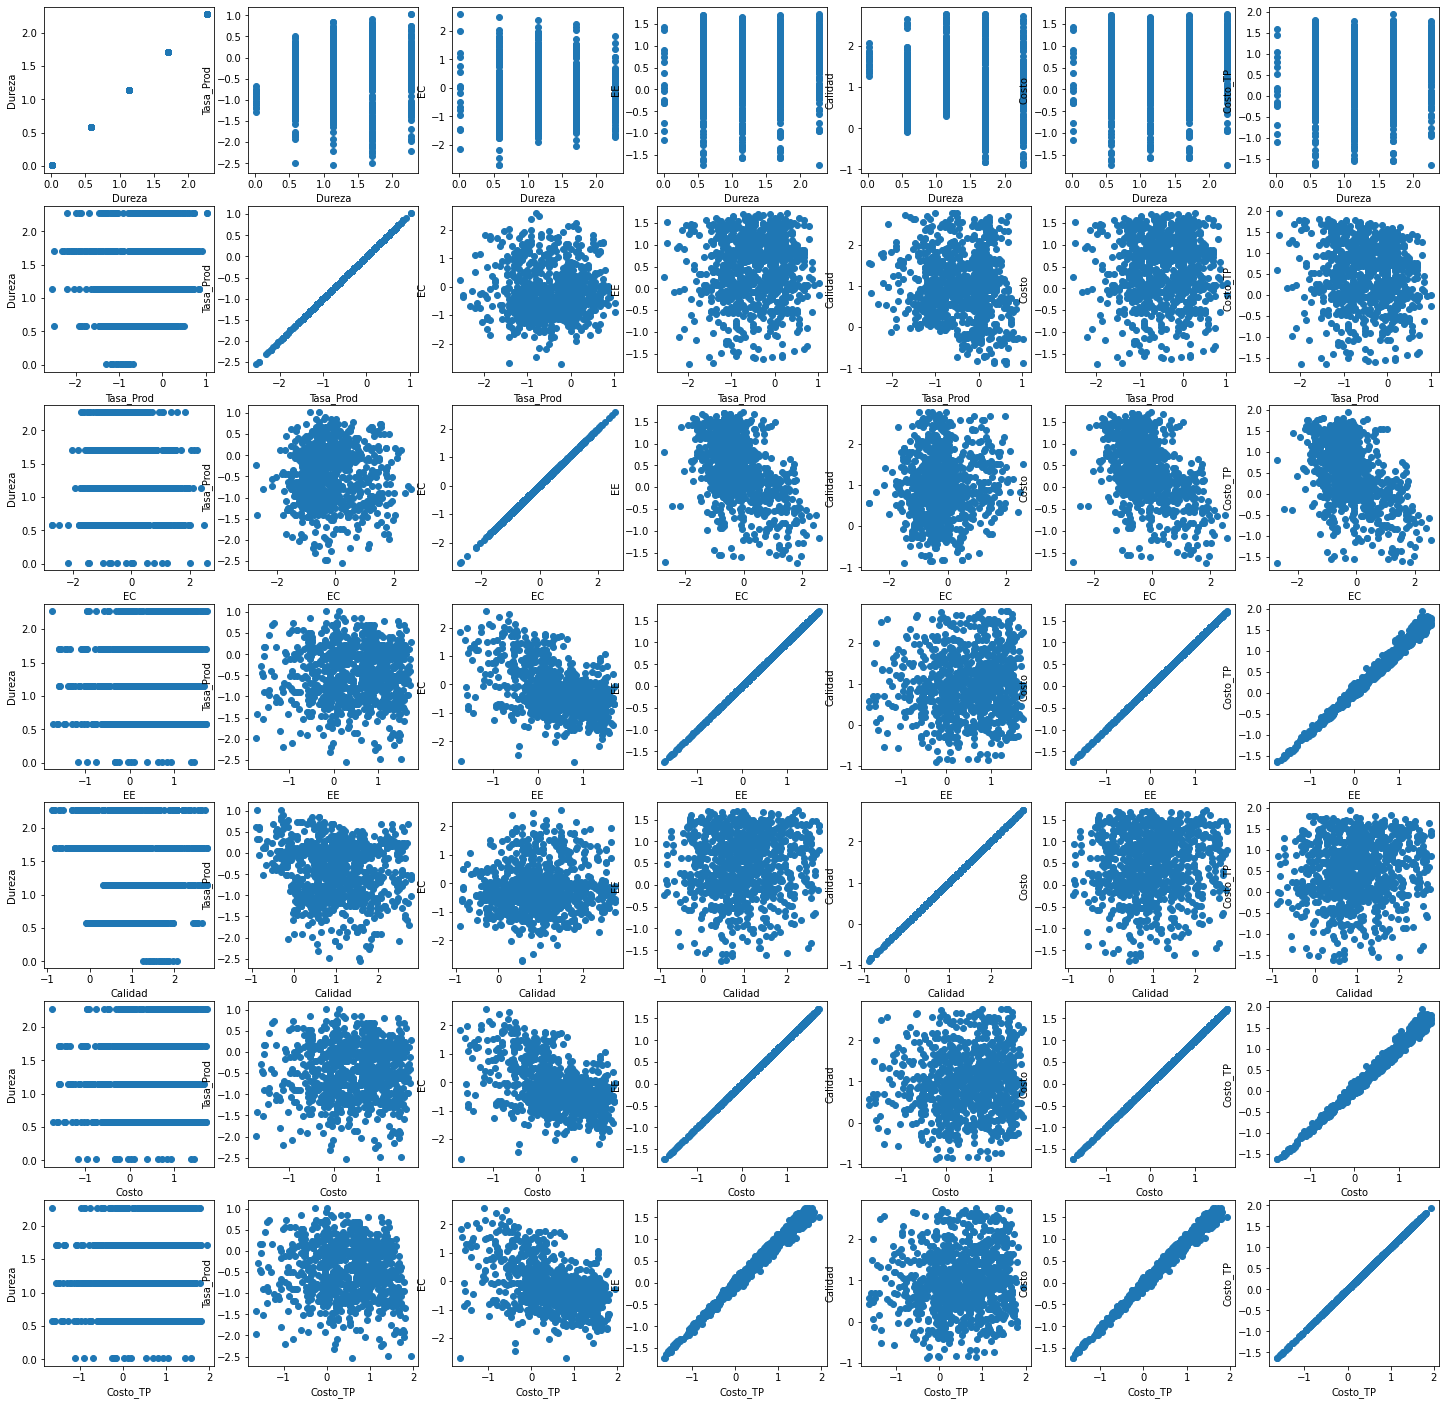

In [91]:
getTableOfScatters(cluster5)

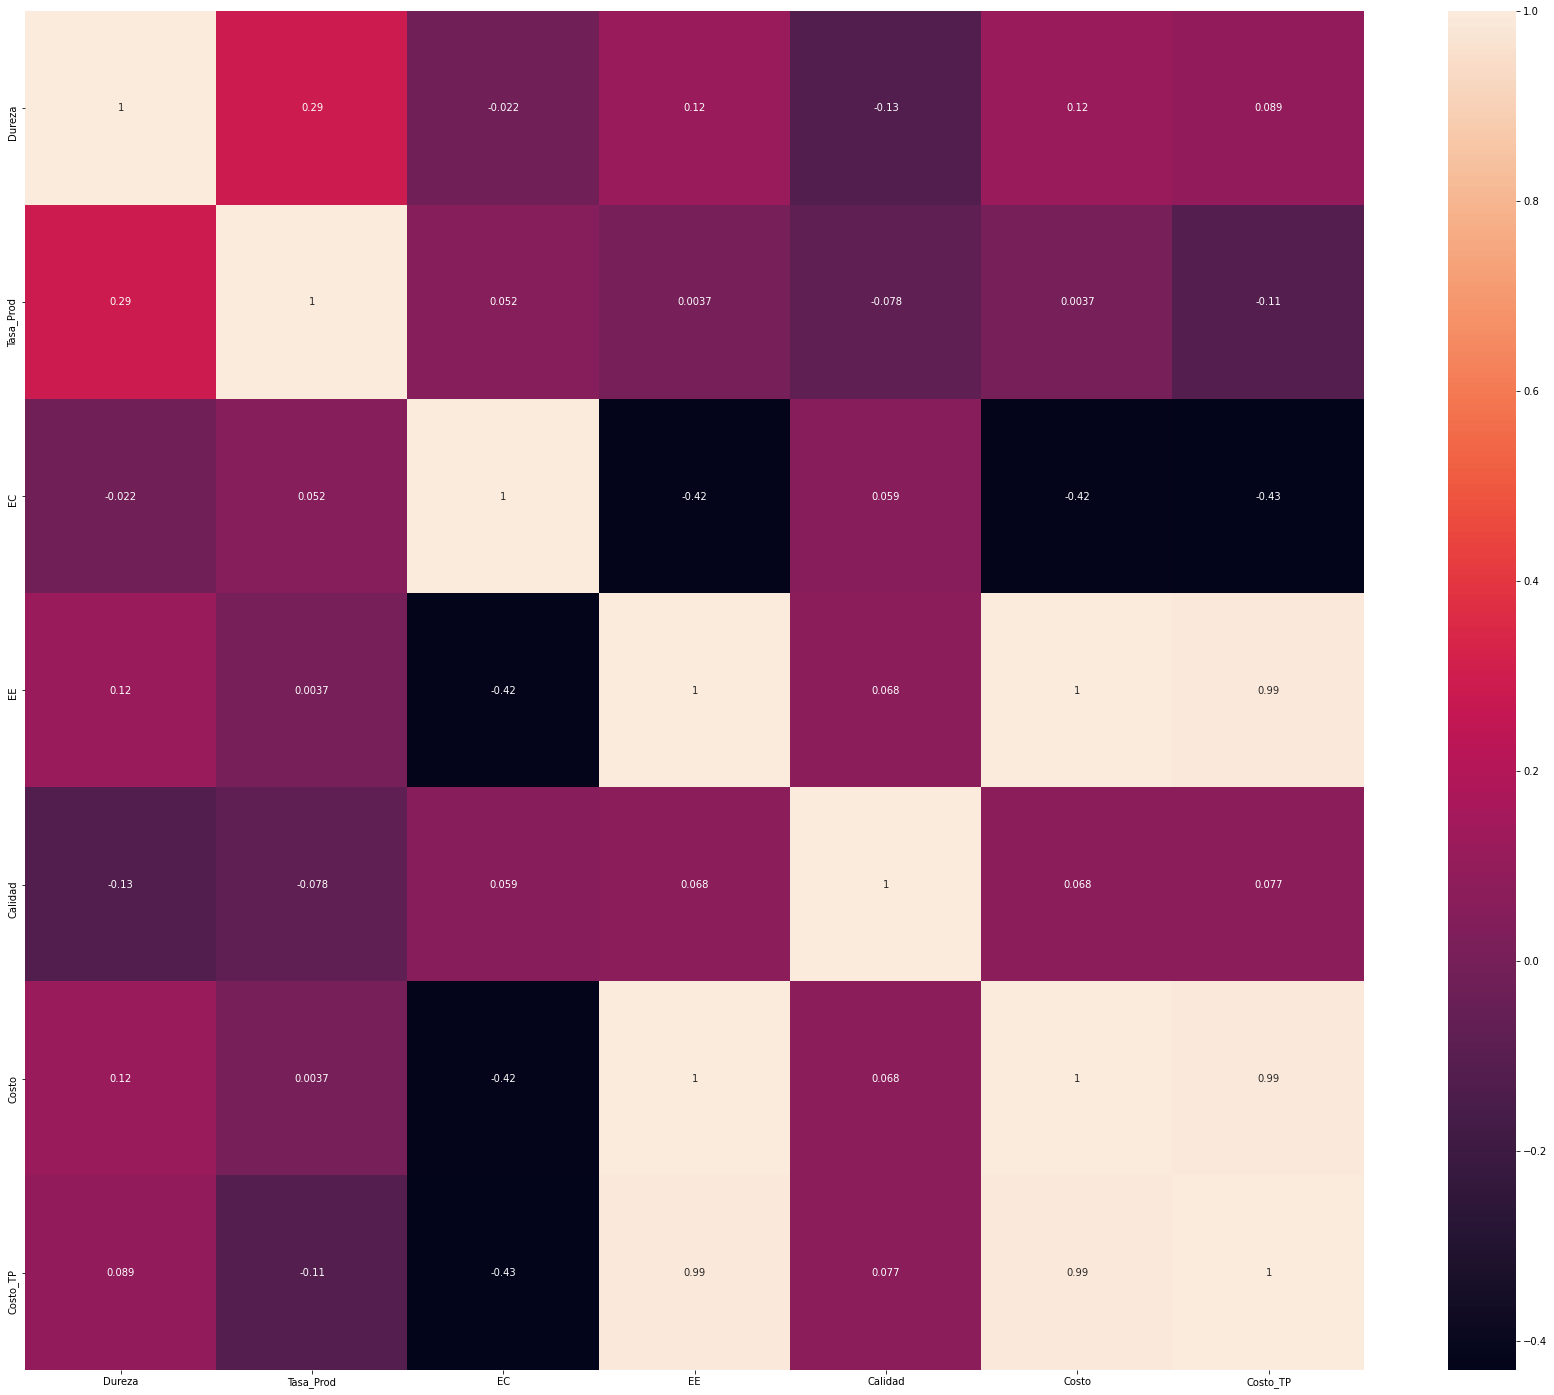

In [92]:
getHeatMap(cluster5, 'spearman')

Al igual que el cluster anterior, este cluster presenta correlaciones mayores que los demás, se reporta el cambio porcentual a continuación.

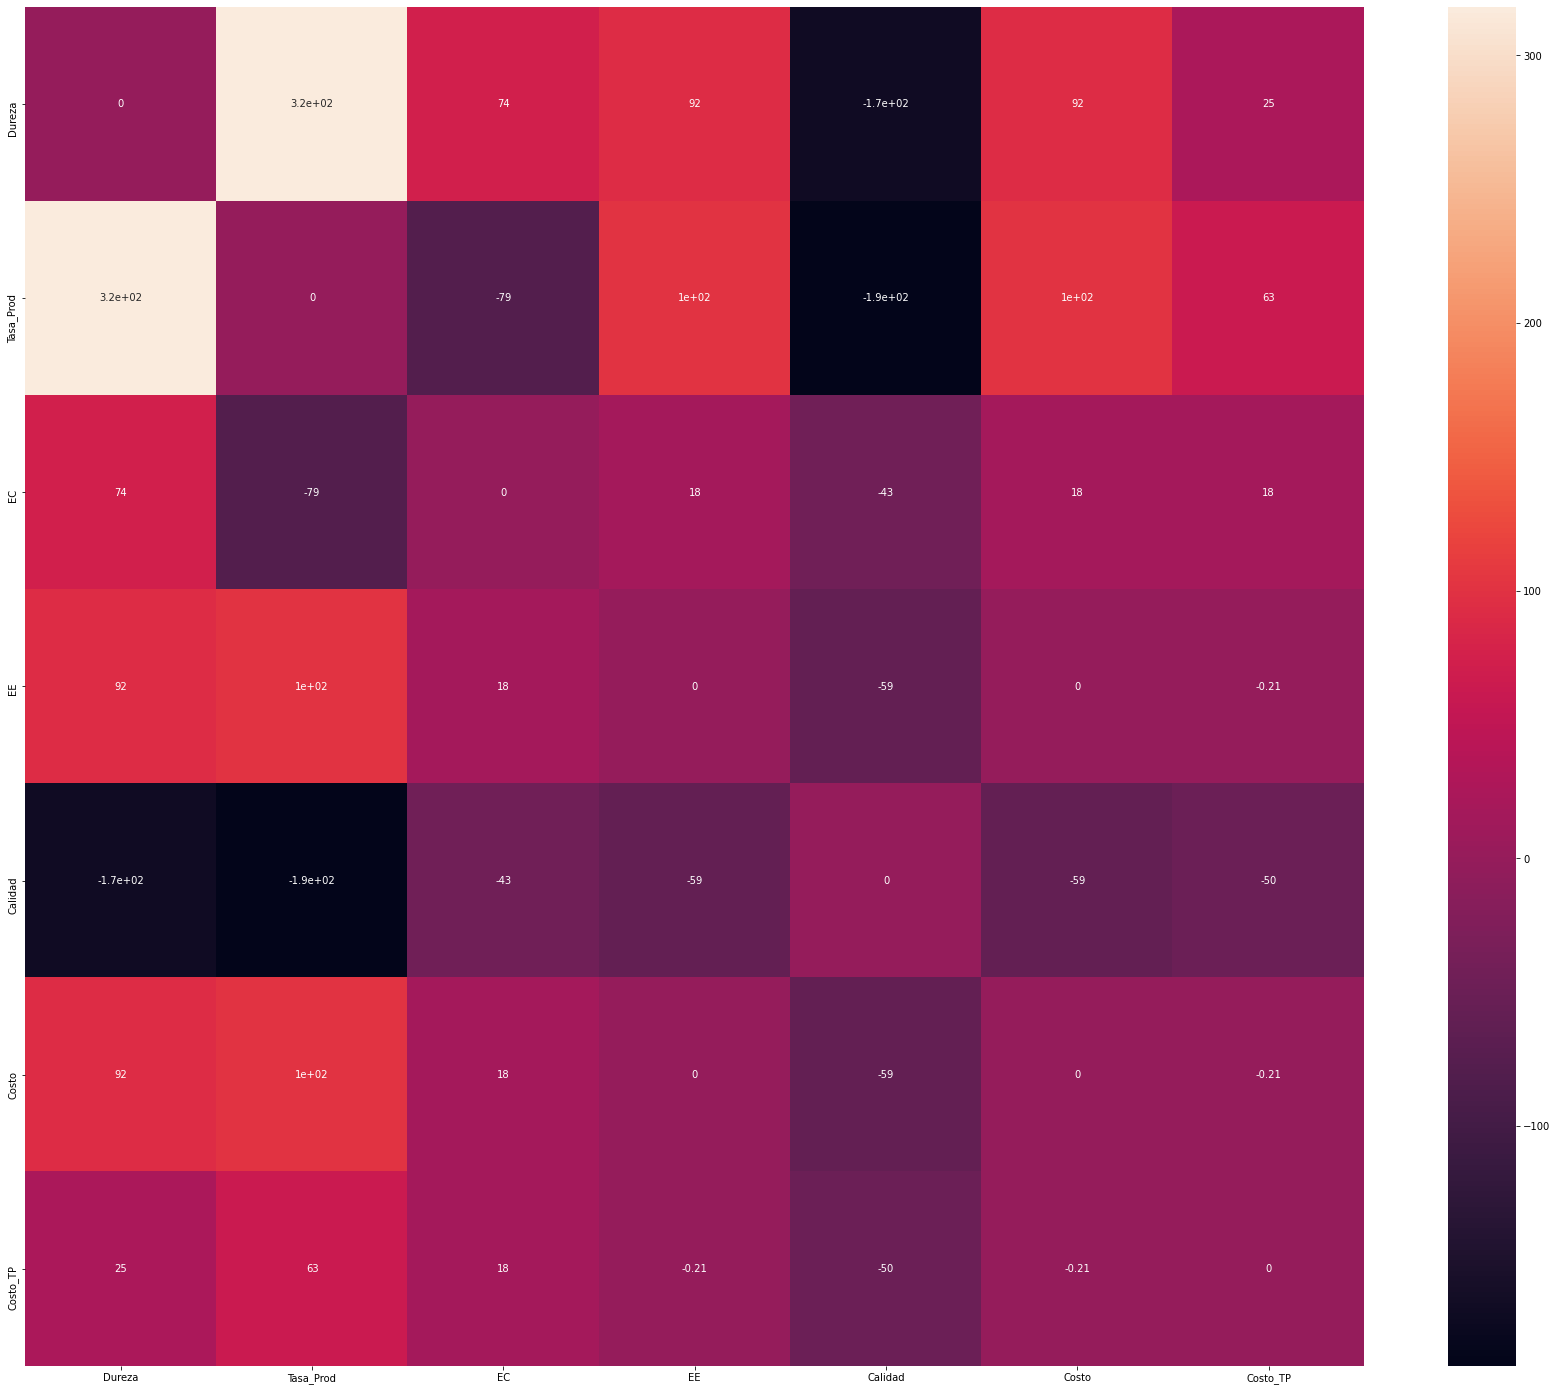

In [93]:
diferencia_porcentual_C5 = (cluster5.corr(method="spearman") - df.corr(method="spearman"))/df.corr(method="spearman").abs() * 100
getHeatMap(diferencia_porcentual_C5, '')

Entre los cambios más reelevates de este cluster se encuentran:

* **Energía Calórica**
  * Tasa de producción: -79%
  * Calidad: -43%
  * Dureza: +74%


* **Energía Eléctrica**
  * Tasa de producción: +100%
  * Calidad: -59%
  * Dureza: +92%


* **Costo por tasa de producción**
  * Tasa de producción: +63%
  * Calidad: -50%
  * Dureza: +25%


In [94]:
get3DChart(cluster5, 35, 1 , 'Cluster 5 3D')

Archivo en: file:///content/cemexVenturesEnergyEfficiencyModelApp/research/3DCharts/Cluster 5 3D.html


## Optimización de los datos


### Cluster 1

In [95]:
cluster1.describe()

Dureza    Tasa_Prod  ...        Costo     Costo_TP
count  2354.000000  2354.000000  ...  2354.000000  2354.000000
mean     -0.810881     0.301070  ...    -0.090742    -0.123009
std       0.533525     0.737206  ...     1.034410     1.013548
min      -1.681429    -1.525021  ...    -2.504670    -2.451745
25%      -1.116736    -0.167581  ...    -0.788082    -0.816942
50%      -0.552043     0.228340  ...    -0.007815    -0.050722
75%      -0.552043     0.737380  ...     0.730188     0.682778
max       0.012650     2.207940  ...     1.799804     1.820426

[8 rows x 7 columns]

##### Intervalo de confianza al 95%

In [96]:
import scipy.stats as st
C1_mu = np.mean(cluster1["Costo_TP"])
C1_sigmaK = np.std(cluster1["Costo_TP"])
C1_sigmaN = np.std(cluster1["Costo_TP"])/np.sqrt(cluster1.shape[0])

CIK_C1 = st.norm.interval(0.95, loc= C1_mu, scale= C1_sigmaK)
CIN_C1 = st.norm.interval(0.95, loc= C1_mu, scale= C1_sigmaN)

#### Mínimos

##### Mínimo General

In [184]:
C1_MIN = cluster1.loc[(cluster1.groupby(["Calidad"])["Costo_TP"].idxmin())]
C1_MIN = C1_MIN.loc[(C1_MIN.groupby(["Dureza", "Tasa_Prod"])["Calidad"].idxmax())]

In [174]:
C1_MIN

Dureza  Tasa_Prod        EC        EE   Calidad     Costo  Costo_TP
4751 -1.681429  -1.298781  0.229372 -2.114536  0.037040 -2.114536 -2.048717
7061 -1.681429  -0.506941  1.108630 -0.723060  0.801904 -0.723060 -0.677317
7139 -1.681429  -0.167581  0.324943 -0.176873  1.034688 -0.176873 -0.168460
7180 -1.681429   0.115219  1.261545 -2.504670  0.735394 -2.504670 -2.451745
5198 -1.681429   0.171780  1.108630 -2.439647 -1.559196 -2.439647 -2.388918
...        ...        ...       ...       ...       ...       ...       ...
1759  0.012650   0.284900  0.592544 -2.504670 -1.525941 -2.504670 -2.451745
2016  0.012650   0.907060  0.038229 -2.504670 -1.825236 -2.504670 -2.451745
431   0.012650   1.020180  1.777632 -2.504670 -1.060372 -2.504670 -2.451745
107   0.012650   1.076740  1.433574 -2.192563 -1.027117 -2.192563 -2.161719
3508  0.012650   1.416100  0.191143 -2.504670 -0.727823 -2.504670 -2.451745

[78 rows x 7 columns]

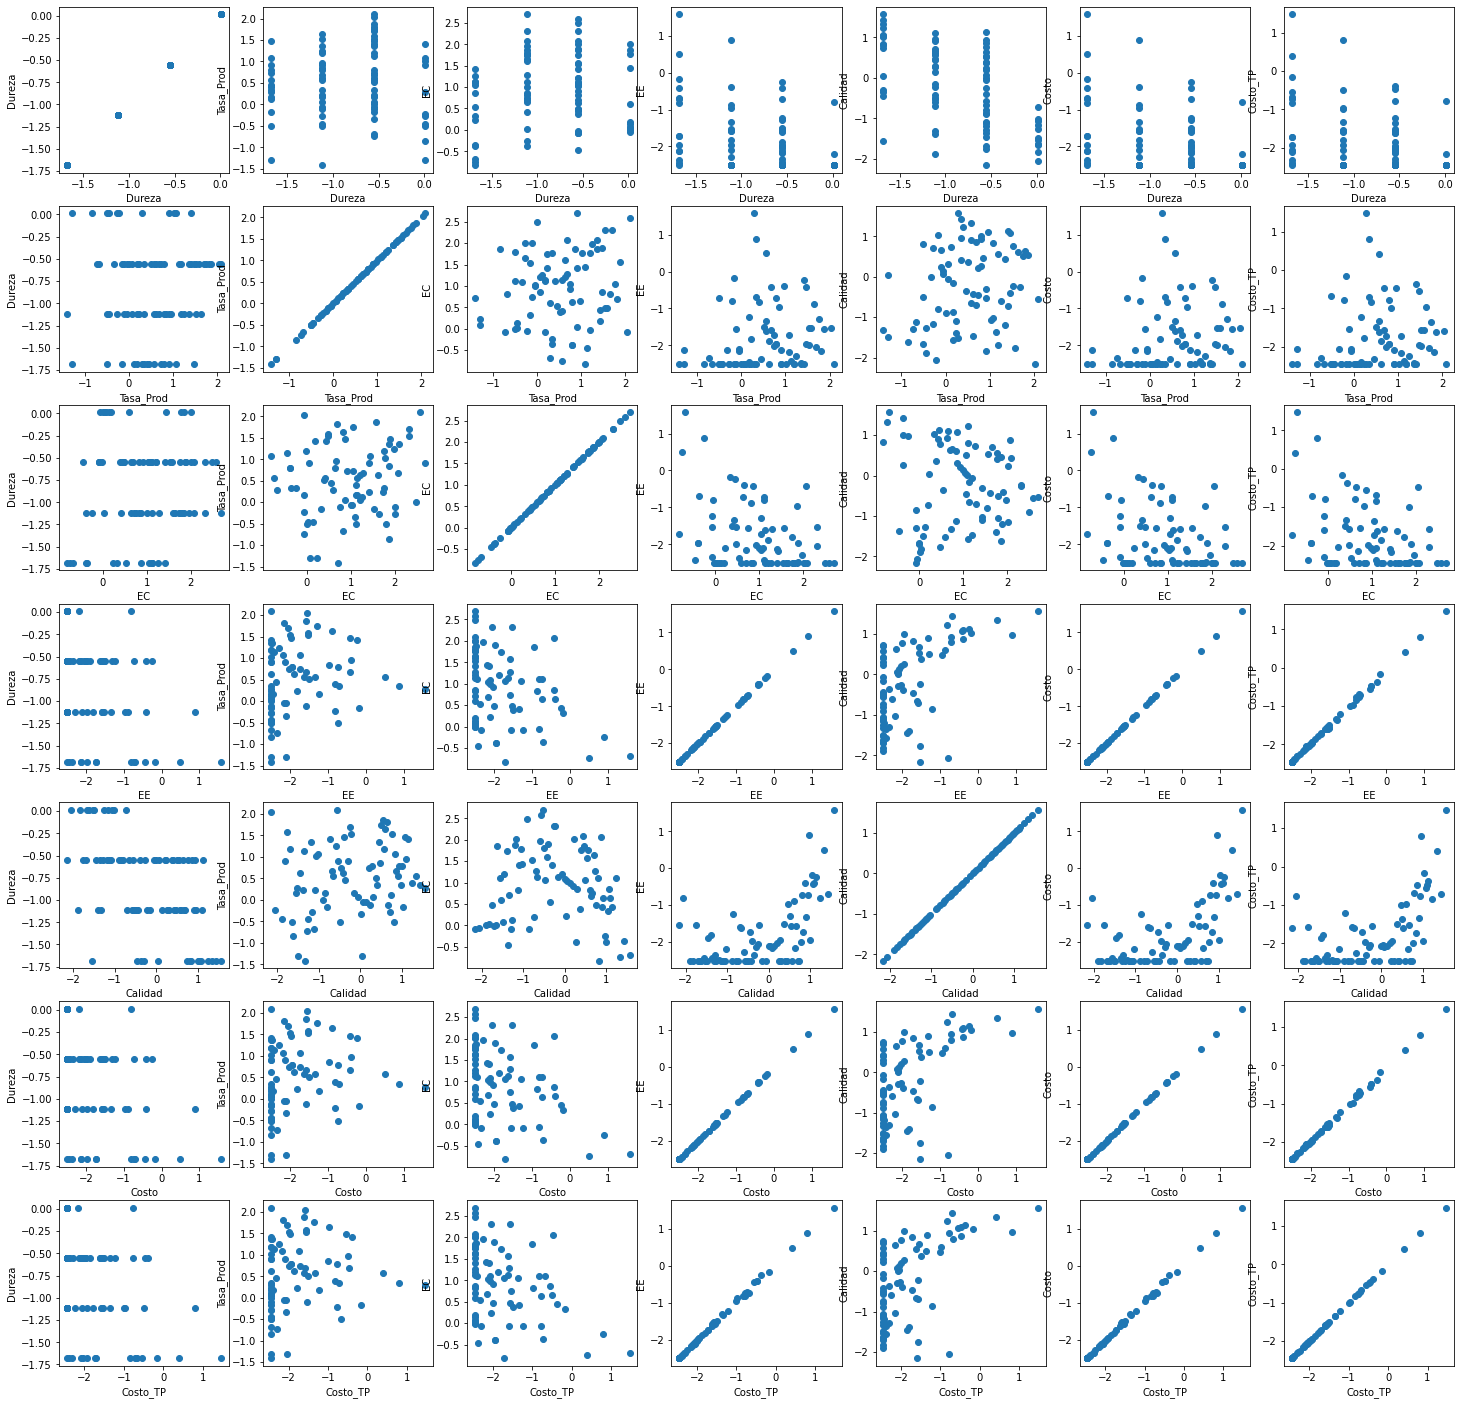

In [177]:
getTableOfScatters(C1_MIN)

##### Mínimo al 95% de confianza

In [194]:
C1_95 = cluster1.loc[cluster1["Costo_TP"].between(CIK_C1[0], CIK_C1[1])]
C1_MIN_95 = C1_95.loc[(C1_95.groupby(["Calidad"])["Costo_TP"].idxmin())]
C1_MIN_95 = C1_MIN_95.loc[(C1_MIN_95.groupby(["Dureza", "Tasa_Prod"])["Calidad"].idxmax())]

In [195]:
C1_MIN_95.describe()

Dureza  Tasa_Prod         EC  ...    Calidad      Costo   Costo_TP
count  75.000000  75.000000  75.000000  ...  75.000000  75.000000  75.000000
mean   -0.913447   0.674032   0.864732  ...  -0.169584  -1.464660  -1.468124
std     0.577072   0.851958   0.905652  ...   0.969929   0.727471   0.693403
min    -1.681429  -1.298781  -1.089516  ...  -2.157785  -2.153549  -2.109070
25%    -1.681429   0.030379   0.277158  ...  -0.943980  -1.964985  -1.949263
50%    -1.116736   0.680820   0.993945  ...  -0.029469  -1.724402  -1.716120
75%    -0.552043   1.444380   1.481360  ...   0.652257  -1.204224  -1.232922
max     0.012650   2.151380   2.599547  ...   1.566767   1.578728   1.474258

[8 rows x 7 columns]

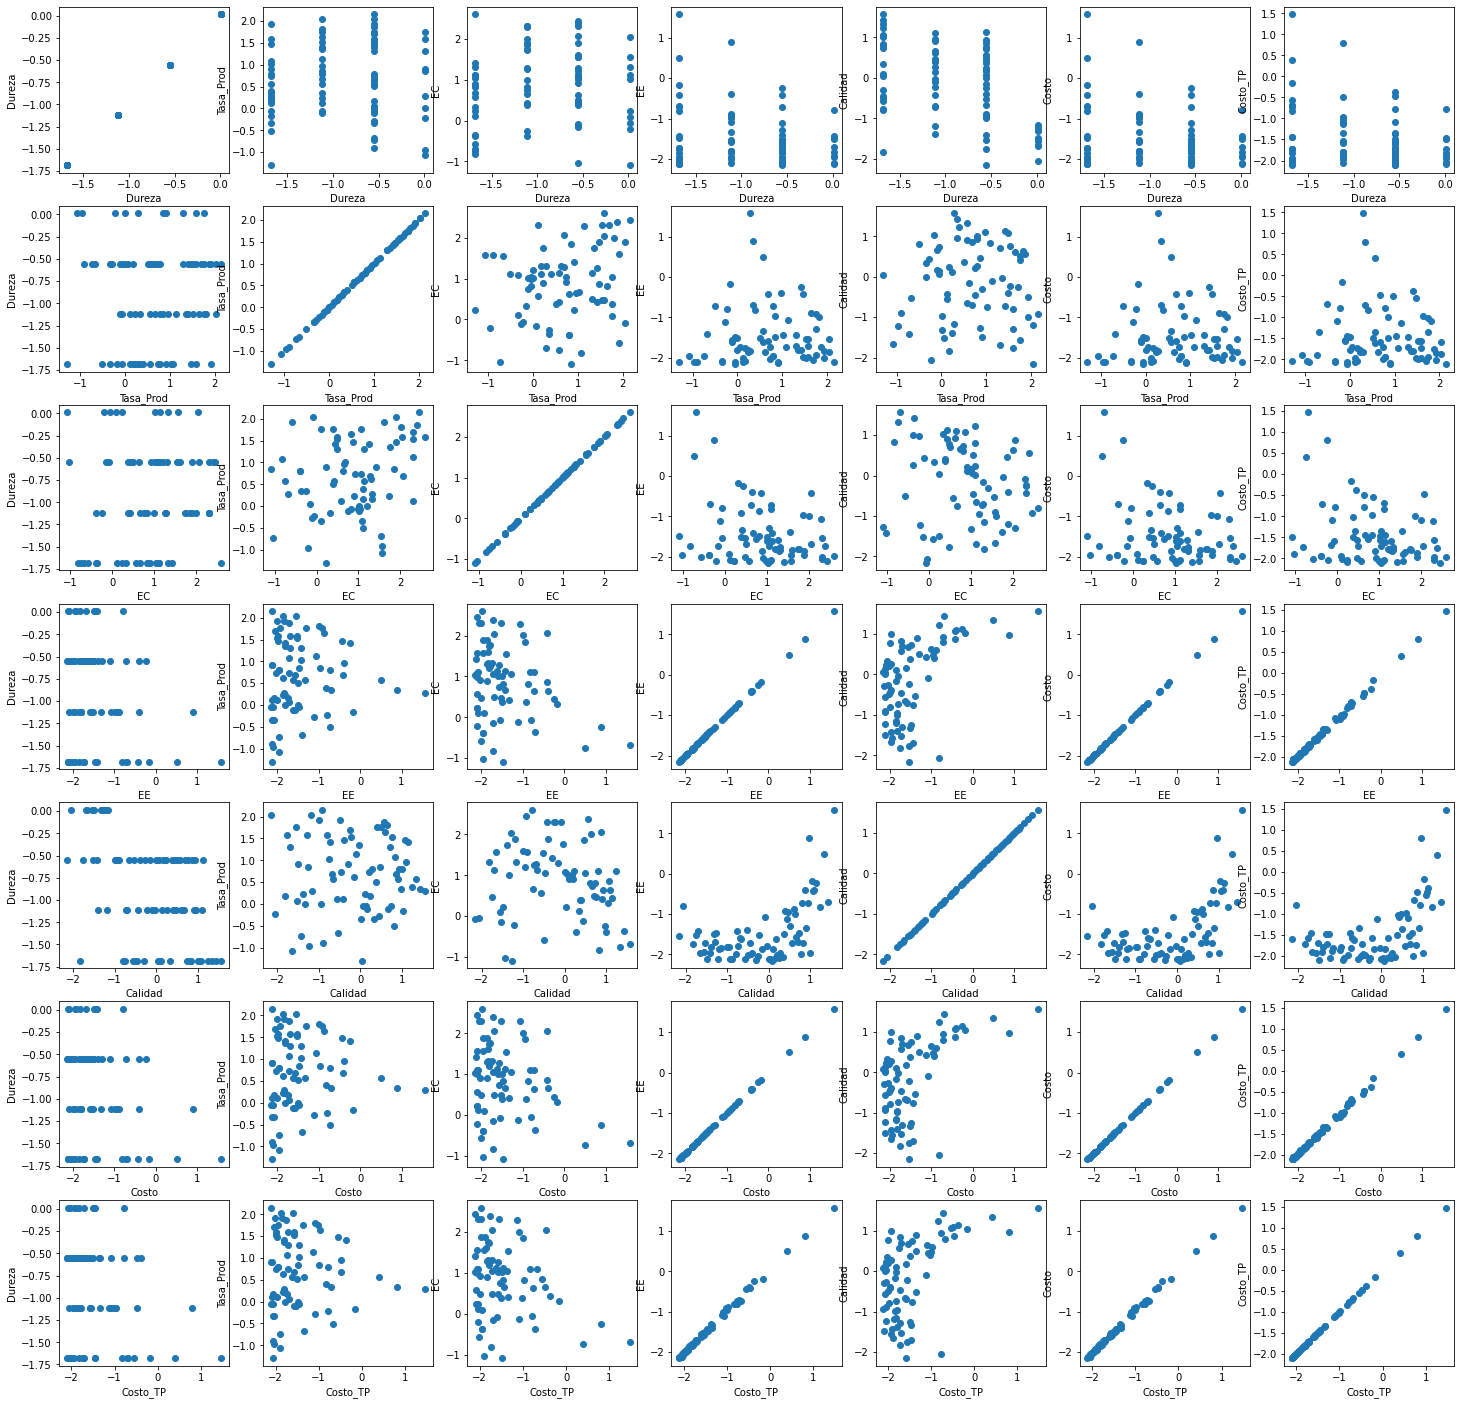

In [196]:
getTableOfScatters(C1_MIN_95)

## Regresión

In [ ]:
clusters = [cluster1, cluster2, cluster3, cluster4, cluster5]

In [ ]:
x_cols = ["Tasa_Prod", "Dureza", "Calidad"]
y_cols = ["Costo_TP"]
#ME = ModelEvaluation(clusters, x_cols, y_cols, 1000)

In [ ]:
from itertools import combinations
df_combinations = len(list(combinations(df.columns, 3)))
df_combinations